In [142]:
!pip install imageio

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.1 -> 25.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


PRIMERA SESSIÓ (AUTÒMATS WOLFRAM HO POSO PER SI DE CAS SINO HO BORREM)

Aplicar una regla de Wolfram

In [143]:
import numpy as np
import matplotlib.pyplot as plt

def get_rule_binary(rule_number):
    """Retorna la representació binària (de 8 bits) d'una regla"""
    return np.array([int(b) for b in np.binary_repr(rule_number, width=8)])

def evolve_1d(state, rule_bin):
    """Aplica una evolució a partir de l'estat actual i la regla binària"""
    new_state = np.zeros_like(state)
    for i in range(1, len(state) - 1):  # no considerem extrems
        neighborhood = state[i-1:i+2]
        index = 7 - int(''.join(map(str, neighborhood)), 2)
        new_state[i] = rule_bin[index]
    return new_state

def simulate_1d_automaton(rule_number, size=101, steps=100):
    rule_bin = get_rule_binary(rule_number)
    states = np.zeros((steps, size), dtype=int)
    states[0, size // 2] = 1  # condició inicial: una cel·la al mig
    
    for t in range(1, steps):
        states[t] = evolve_1d(states[t-1], rule_bin)
    
    return states

def plot_1d_automaton(states, rule_number):
    plt.figure(figsize=(12, 6))
    plt.imshow(states, cmap="binary", interpolation="nearest")
    plt.title(f"Autòmat cel·lular 1D - Regla {rule_number}")
    plt.xlabel("Cel·les")
    plt.ylabel("Temps")
    plt.show()

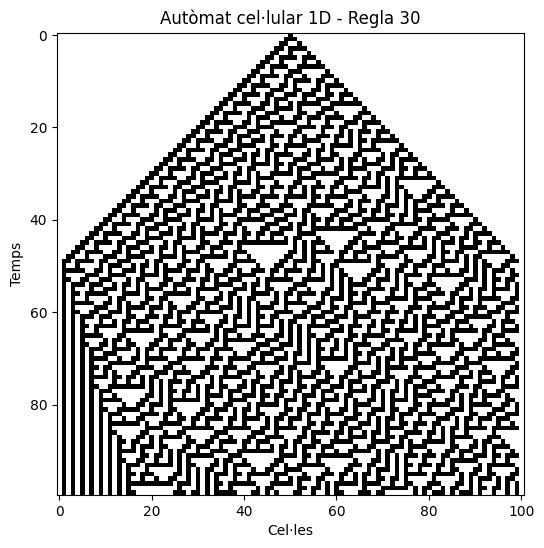

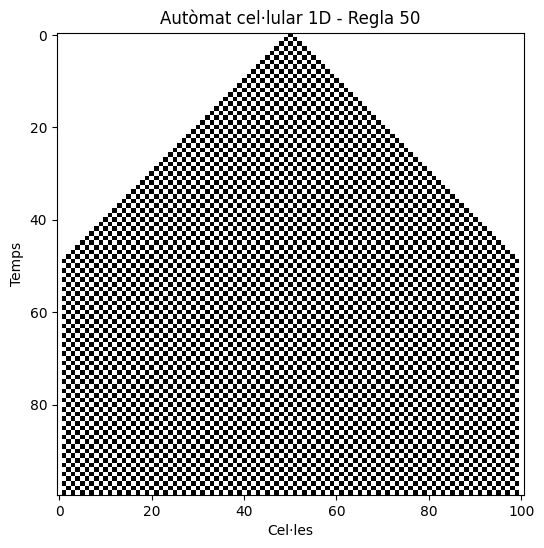

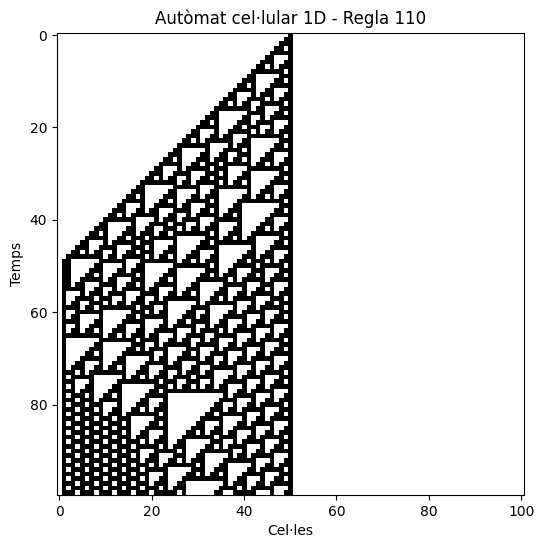

In [144]:
rule = 30
states = simulate_1d_automaton(rule_number=rule, size=101, steps=100)
plot_1d_automaton(states, rule)
rule = 50
states = simulate_1d_automaton(rule_number=rule, size=101, steps=100)
plot_1d_automaton(states, rule)
rule = 110
states = simulate_1d_automaton(rule_number=rule, size=101, steps=100)
plot_1d_automaton(states, rule)

Combinació de dues regles

In [145]:
def simulate_multirule_1d(rule1, rule2, size=101, steps=100):
    rule_bin1 = get_rule_binary(rule1)
    rule_bin2 = get_rule_binary(rule2)

    states = np.zeros((steps, size), dtype=int)
    states[0, size // 2] = 1

    for t in range(1, steps):
        if t % 2 == 0:
            states[t] = evolve_1d(states[t-1], rule_bin1)
        else:
            states[t] = evolve_1d(states[t-1], rule_bin2)
    
    return states

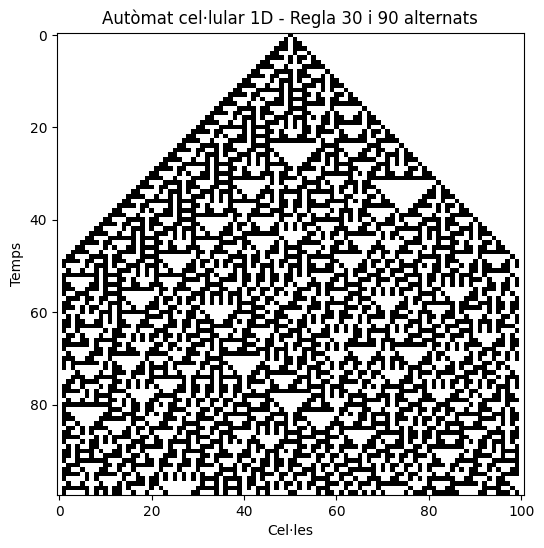

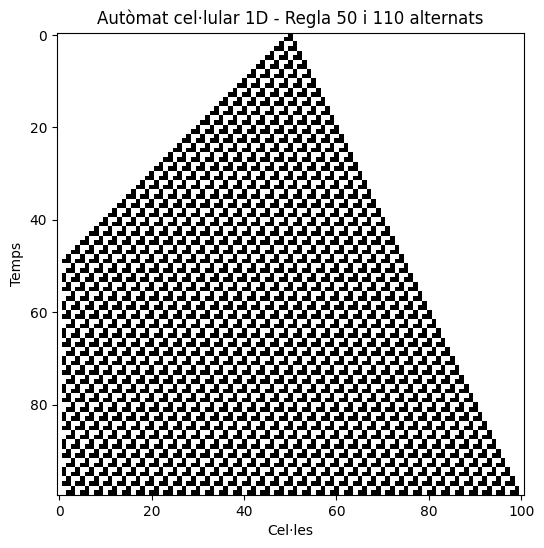

In [146]:
states = simulate_multirule_1d(rule1=30, rule2=90, size=101, steps=100)
plot_1d_automaton(states, "30 i 90 alternats")

states = simulate_multirule_1d(rule1=50, rule2=110, size=101, steps=100)
plot_1d_automaton(states, "50 i 110 alternats")

SEGONA SESSIÓ I PRÀCTICA

In [147]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import os

np.random.seed(30042025) 

In [148]:
import shutil

def clear_output_folder(folder):
    if os.path.exists(folder):
        shutil.rmtree(folder)
    os.makedirs(folder)

clear_output_folder("frames_ambvent")
clear_output_folder("frames_novent")

In [149]:
import imageio.v2 as imageio
from IPython.display import Image, display
import os

def make_gif(frame_folder, gif_name):
    images = []
    files = sorted([f for f in os.listdir(frame_folder) if f.endswith(".png")])
    for filename in files:
        img_path = os.path.join(frame_folder, filename)
        images.append(imageio.imread(img_path))
    
    imageio.mimsave(gif_name, images, duration=0.3)

    # Mostra el GIF dins del notebook
    display(Image(filename=gif_name))

LLEGIR DADES SIMULADES

In [150]:
def read_img(path, shape):
    with open(path, 'rb') as f:
        data = np.fromfile(f, dtype=np.int16)
    return data.reshape(shape)

INICIALITZACIÓ DE LES CAPES

In [151]:
shape = (50, 50)

# Carreguem les capes
vegetation = read_img('vegetation.img', shape)
humidity = read_img('humidity.img', shape)

# Estat de les cel·les: 0 = pendent, 1 = cremant, 2 = cremat
state = np.zeros(shape, dtype=int)

# Inicialitzem foc en diversos punts aleatoris
num_initial_fires = 10
initial_fire_coords = np.random.choice(np.arange(shape[0]*shape[1]), num_initial_fires, replace=False)
for idx in initial_fire_coords:
    i, j = divmod(idx, shape[1])
    state[i, j] = 1

# Capes auxiliars per controlar humitat i vegetació cremant
humidity_timer = np.zeros_like(humidity)
vegetation_timer = np.zeros_like(vegetation)


FUNCIÓ D'ACTUALITZACIÓ DEL FOC

In [152]:
def update_fire(state, humidity, vegetation, humidity_timer, vegetation_timer):
    new_state = state.copy()
    new_humidity_timer = humidity_timer.copy()
    new_vegetation_timer = vegetation_timer.copy()

    for i in range(state.shape[0]):
        for j in range(state.shape[1]):
            if state[i, j] == 1:  # Cel·la cremant
                new_vegetation_timer[i, j] += 1
                if new_vegetation_timer[i, j] >= vegetation[i, j]:
                    new_state[i, j] = 2  # Crema completada
            elif state[i, j] == 0:  # Cel·la pendent
                # Mirem els 8 veïns
                neighbors = [(i-1,j-1), (i-1,j), (i-1,j+1),
                             (i,j-1),           (i,j+1),
                             (i+1,j-1), (i+1,j), (i+1,j+1)]
                for ni, nj in neighbors:
                    if 0 <= ni < state.shape[0] and 0 <= nj < state.shape[1]:
                        if state[ni, nj] == 1:
                            new_humidity_timer[i, j] += 1
                            if new_humidity_timer[i, j] >= humidity[i, j]:
                                new_state[i, j] = 1  # Comença a cremar
                            break
    return new_state, new_humidity_timer, new_vegetation_timer

SIMULAR I VISUALITZAR

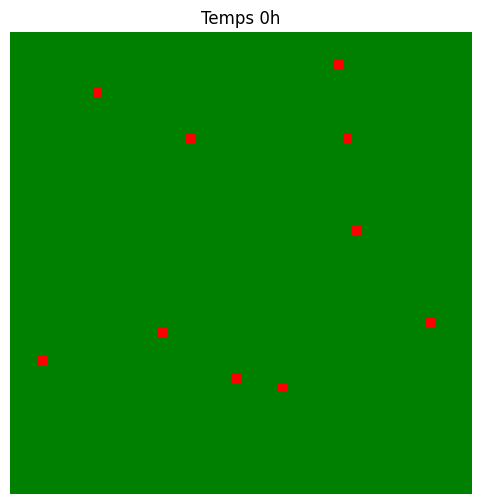

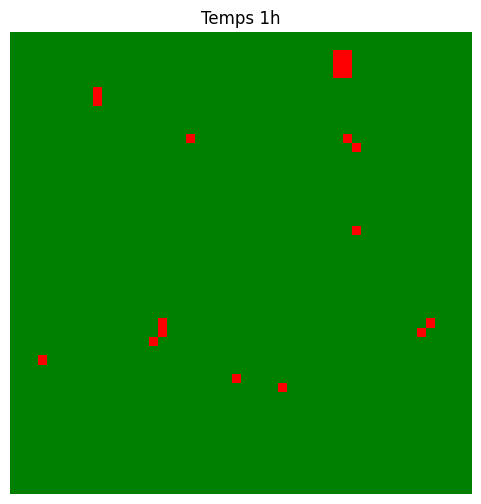

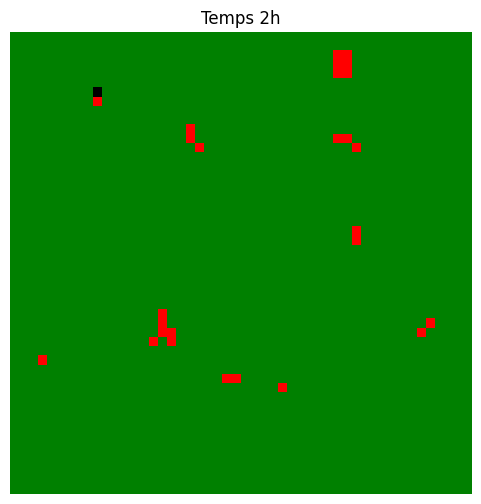

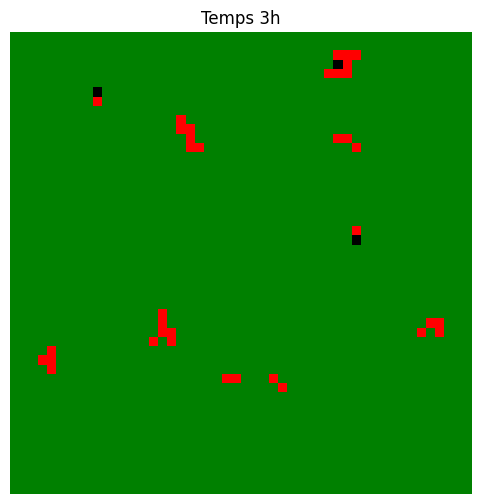

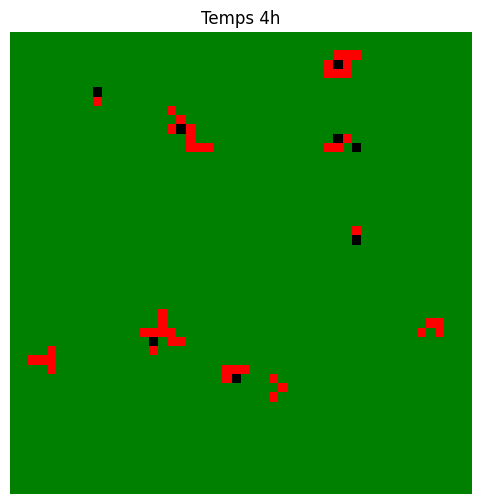

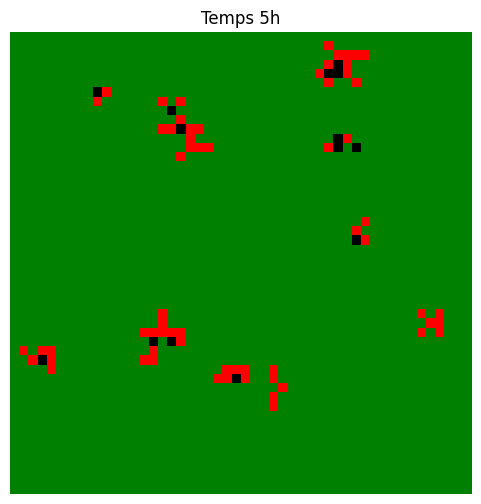

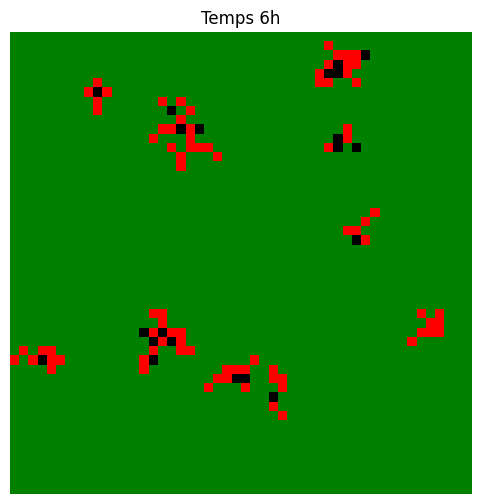

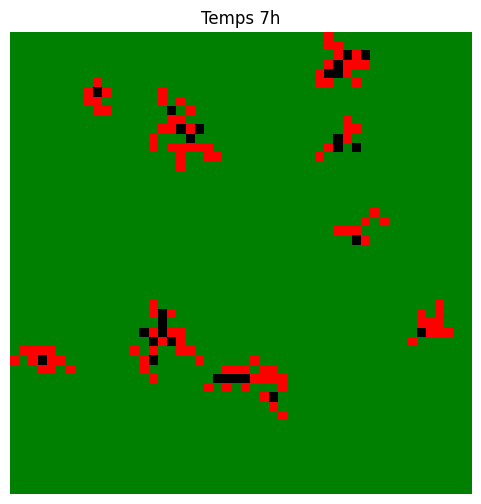

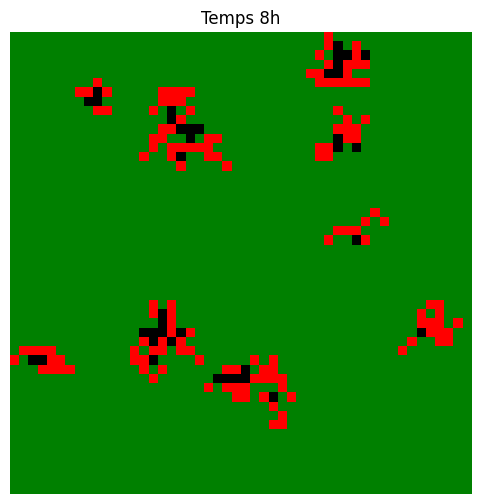

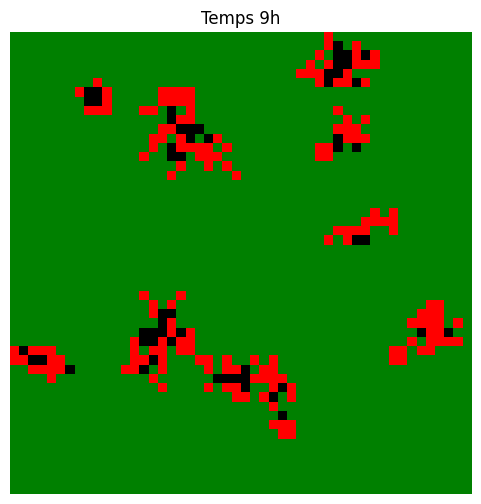

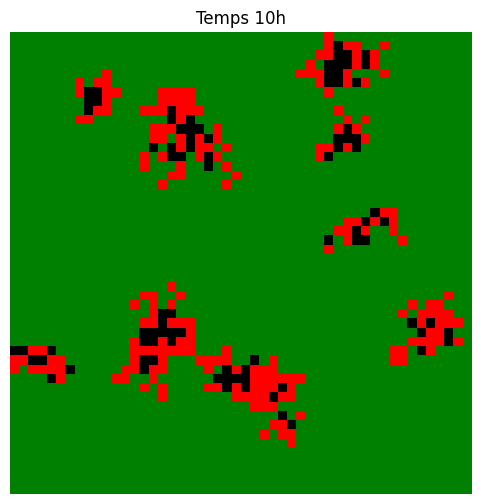

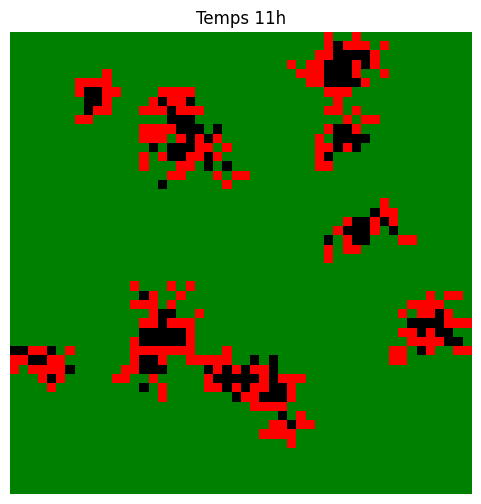

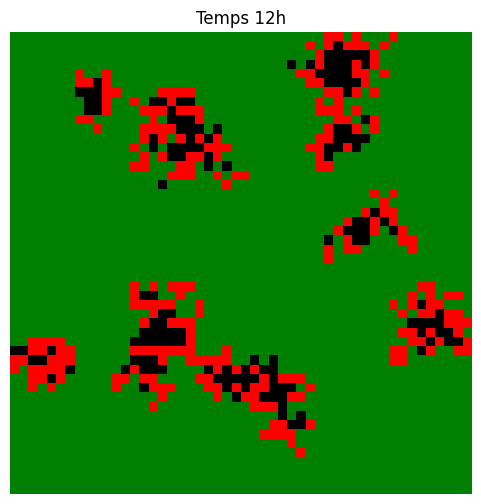

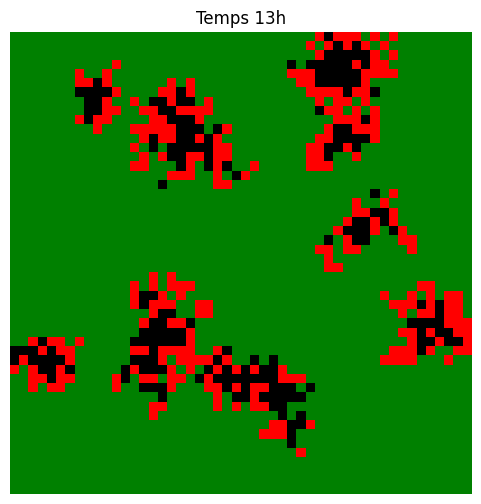

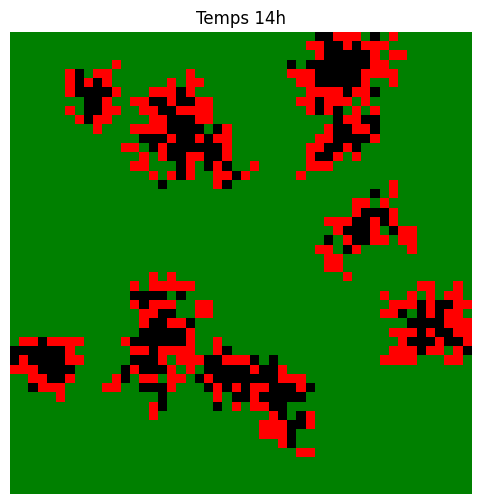

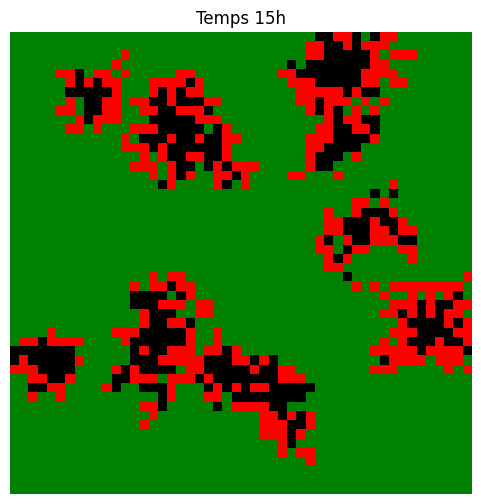

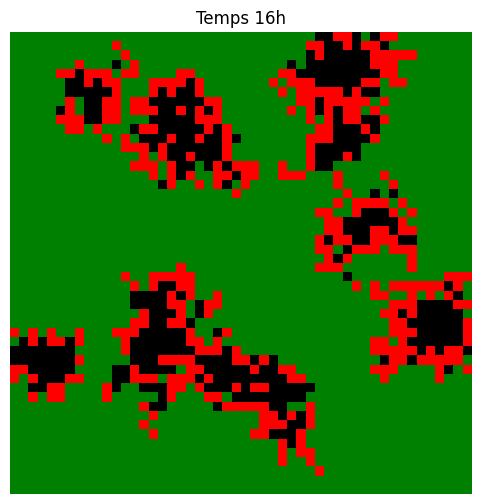

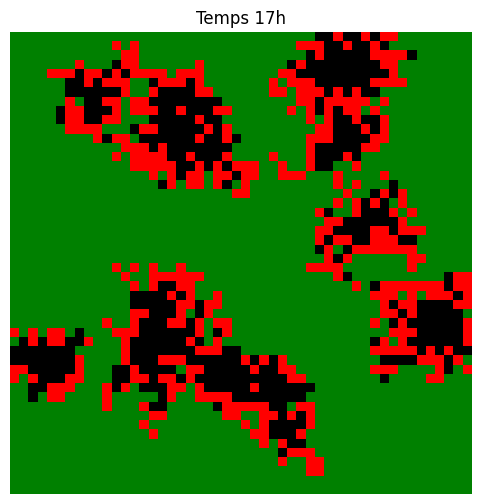

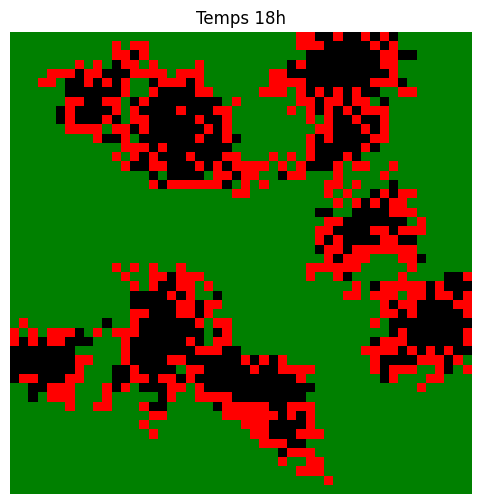

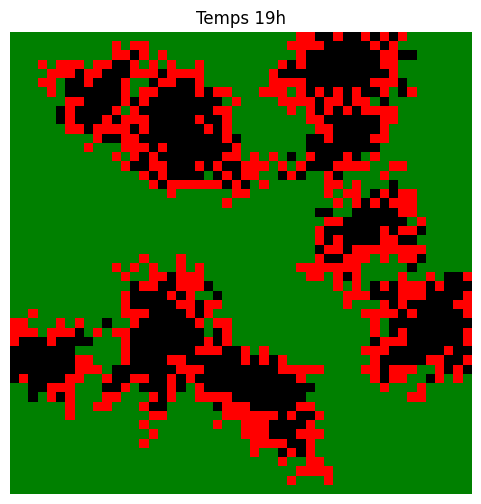

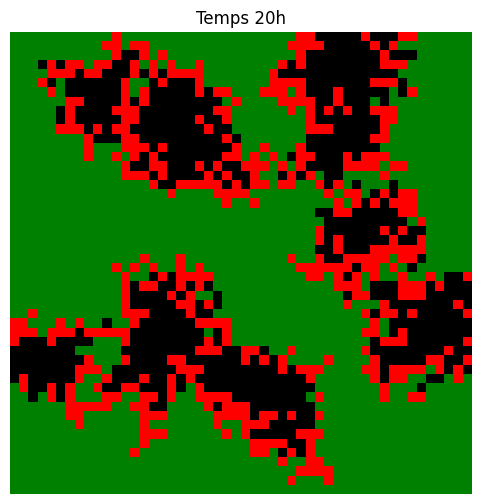

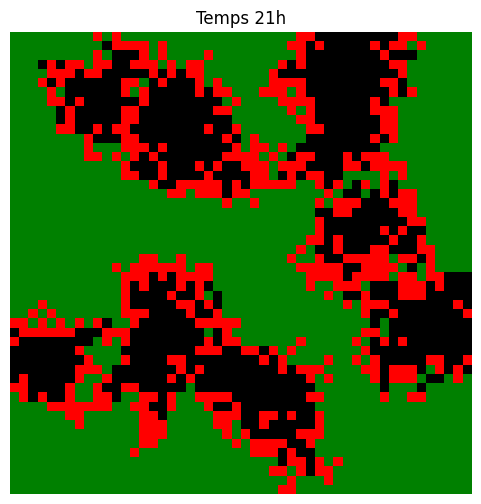

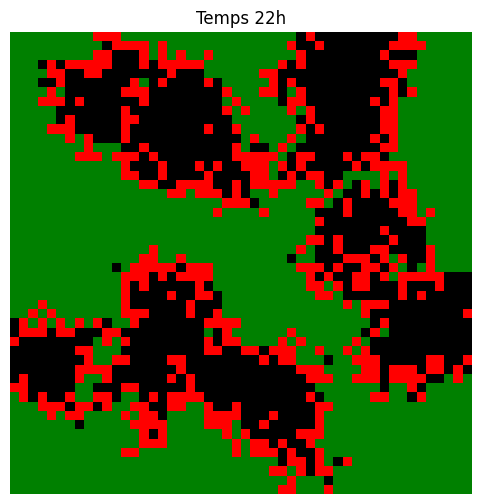

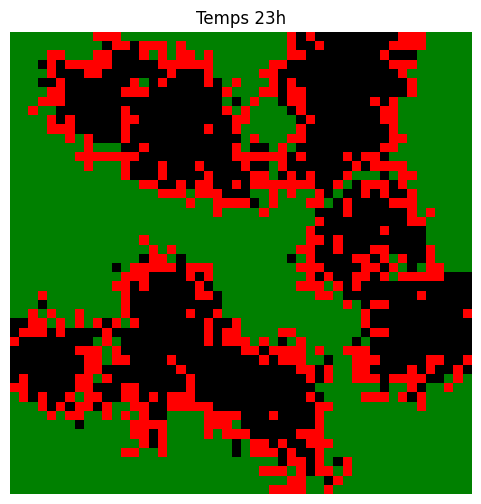

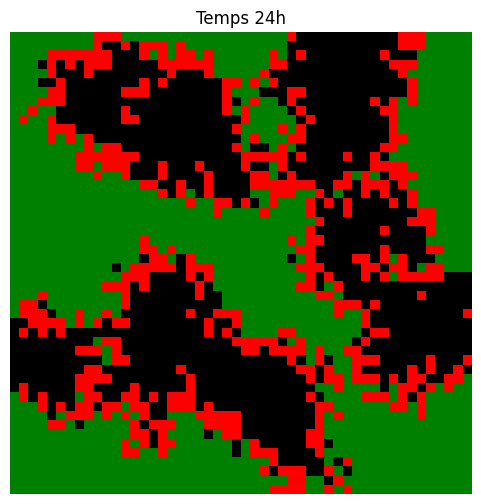

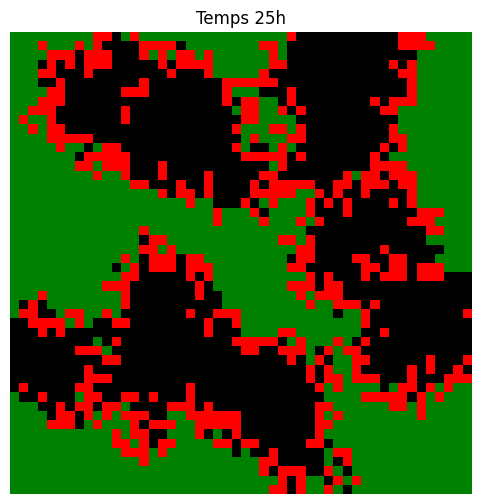

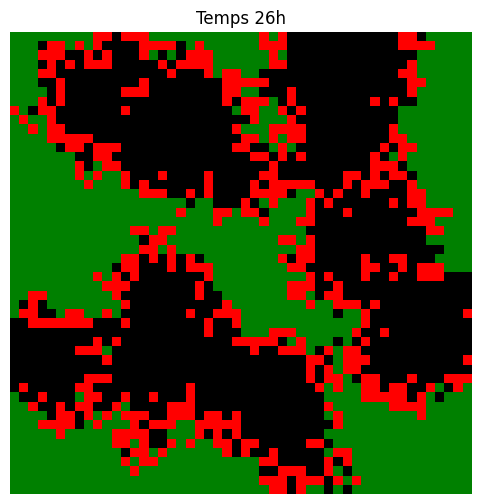

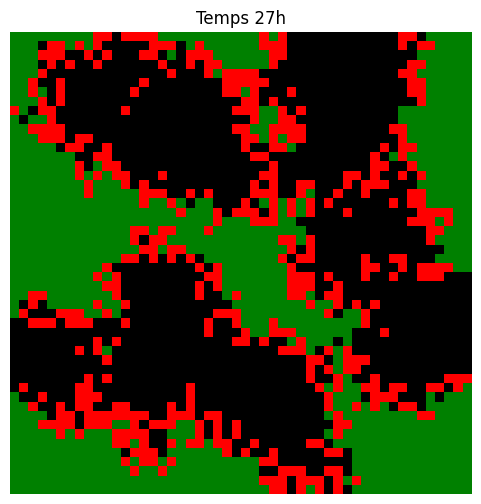

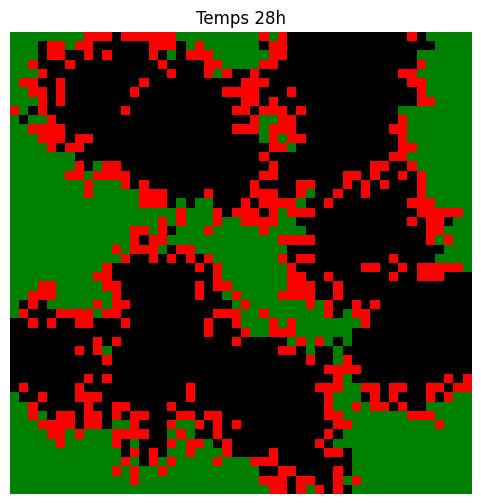

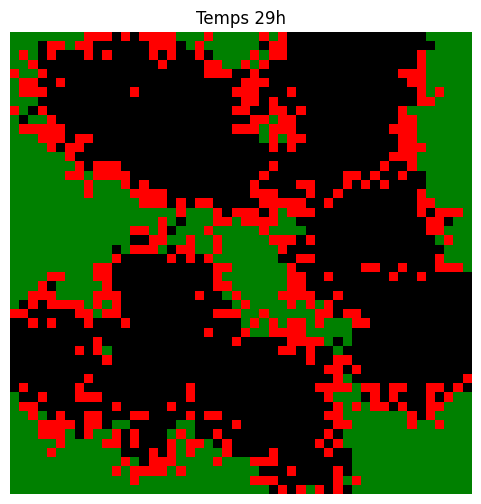

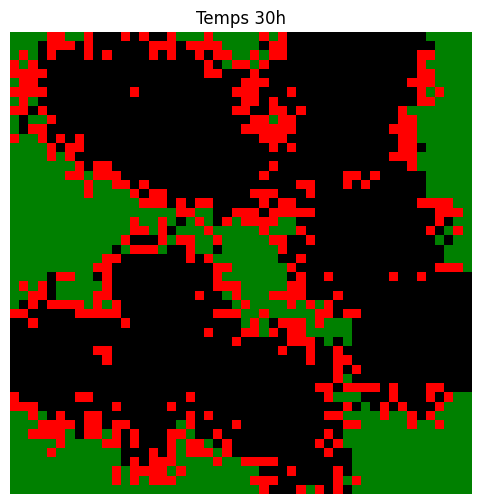

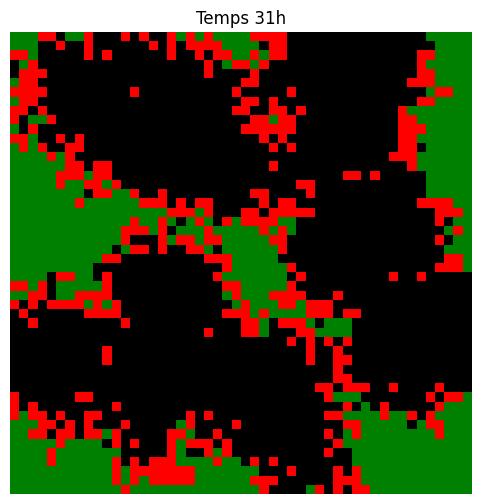

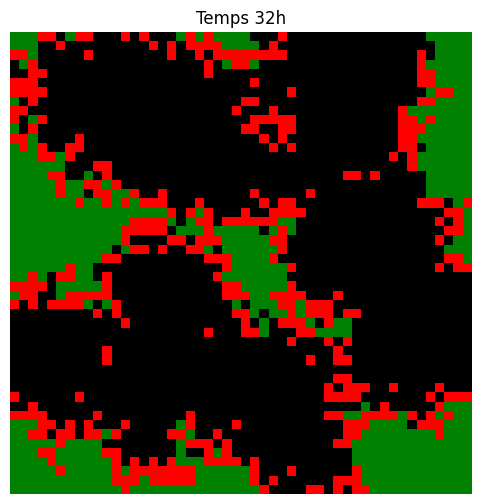

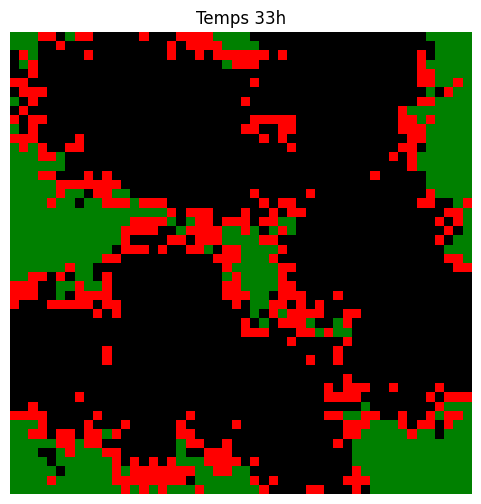

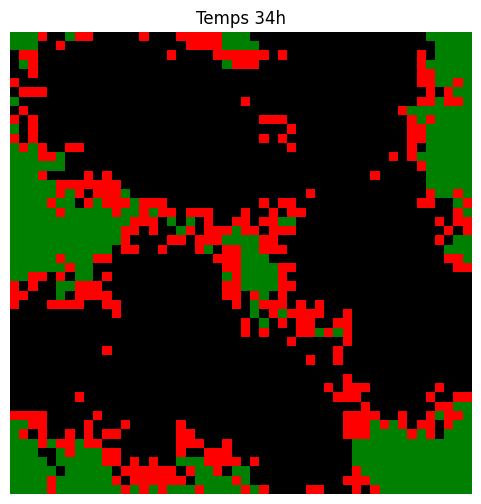

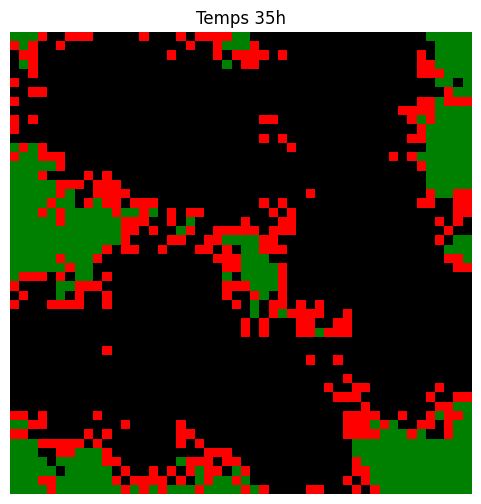

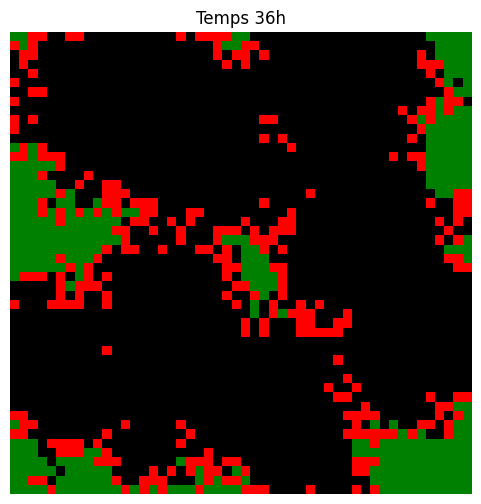

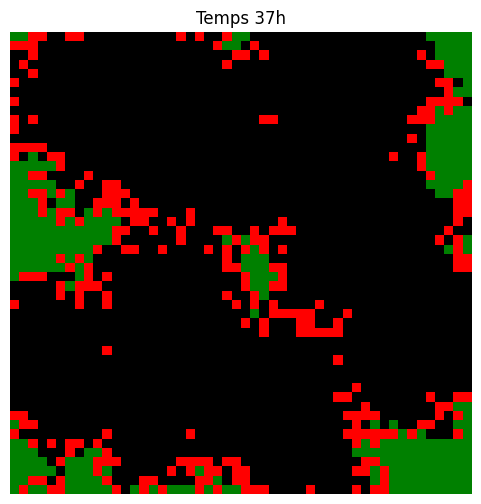

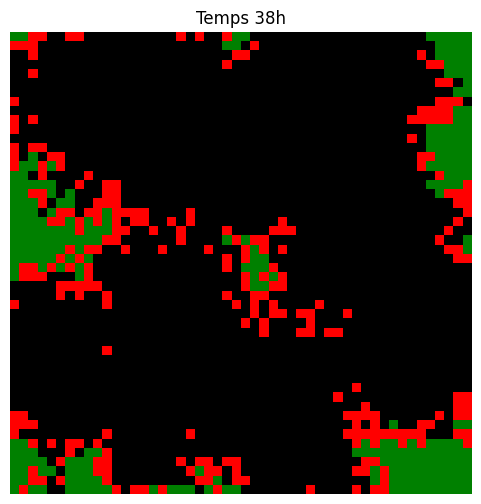

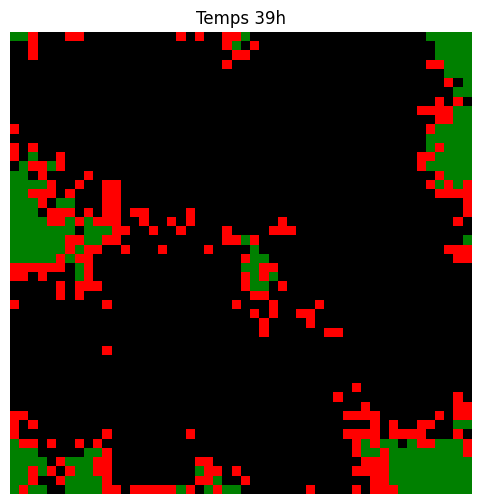

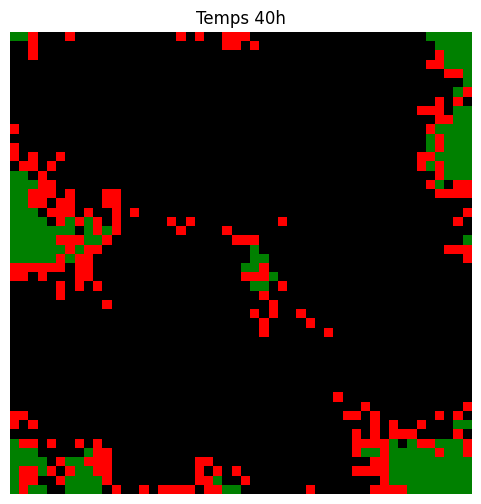

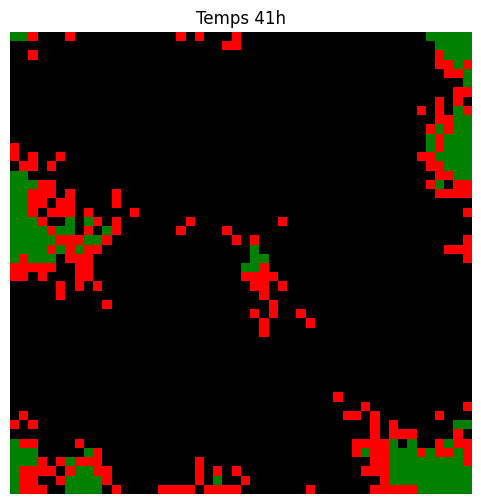

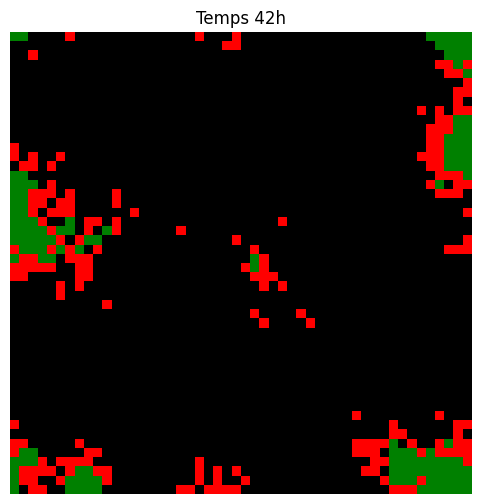

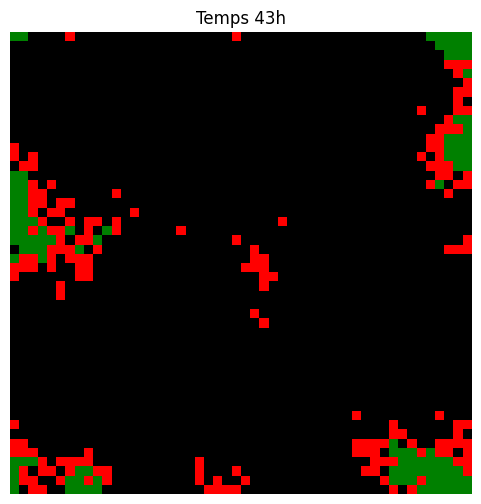

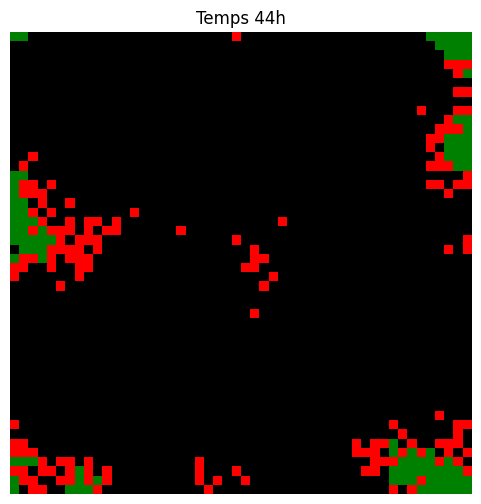

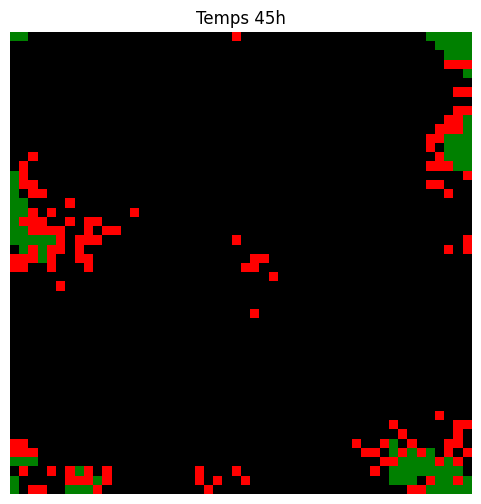

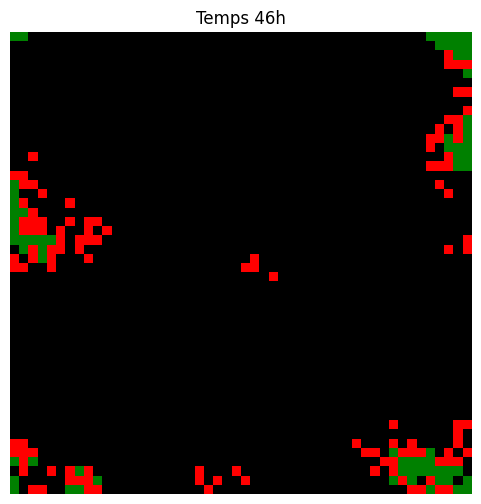

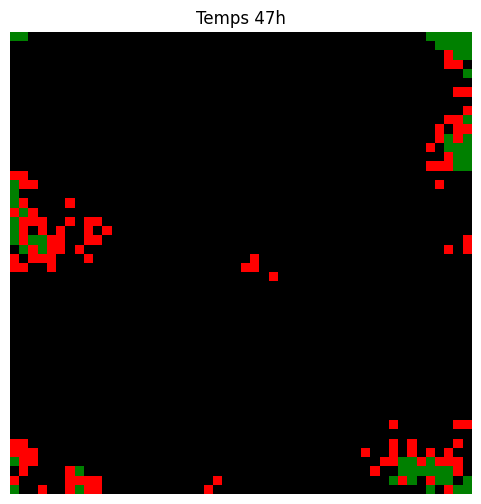

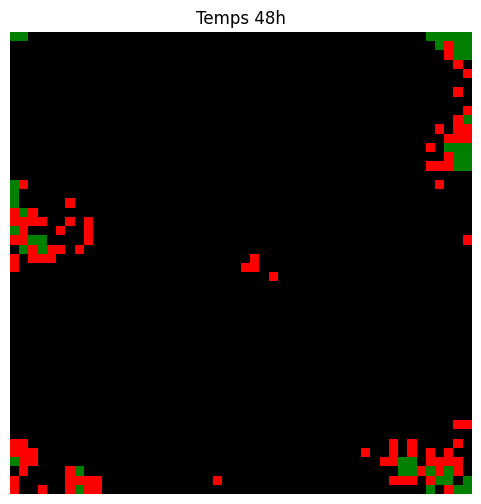

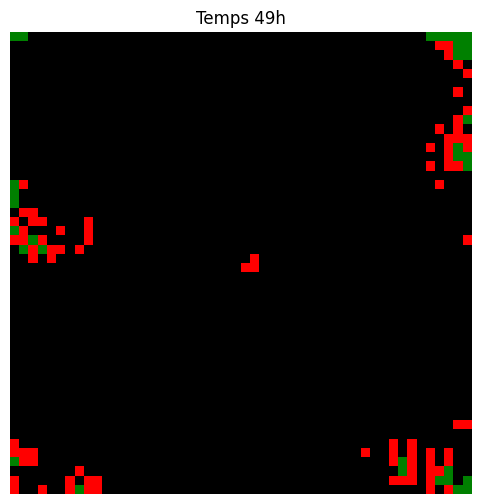

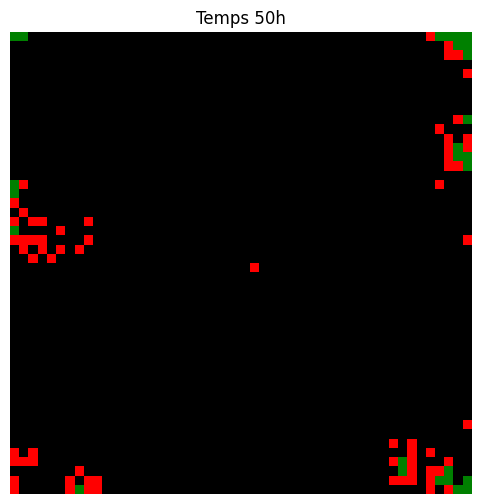

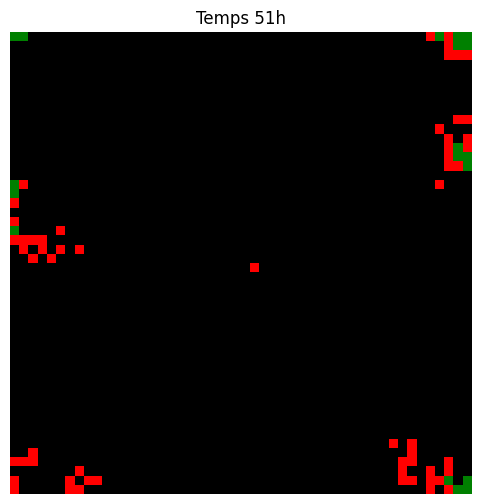

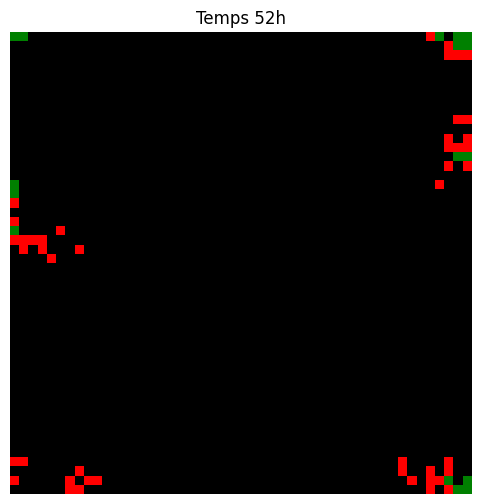

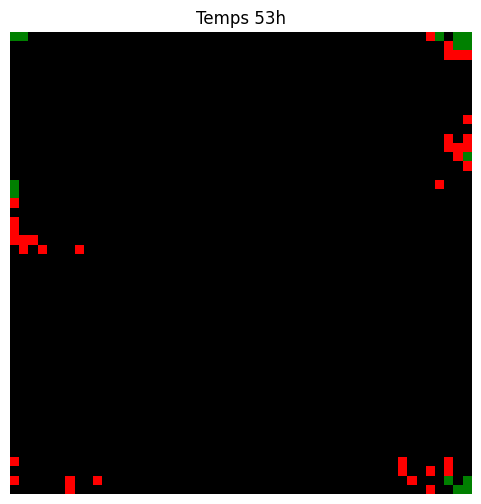

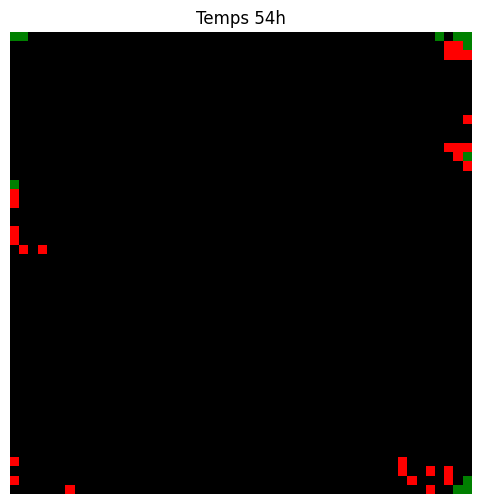

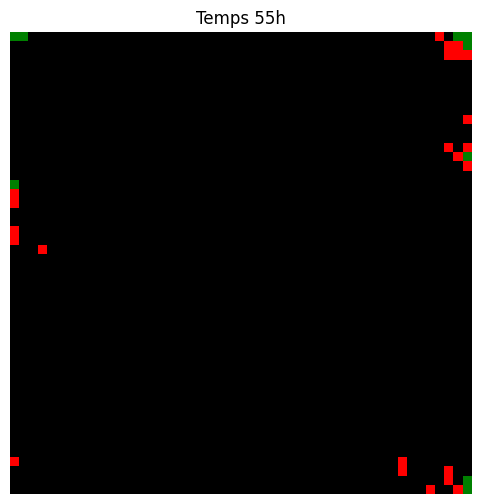

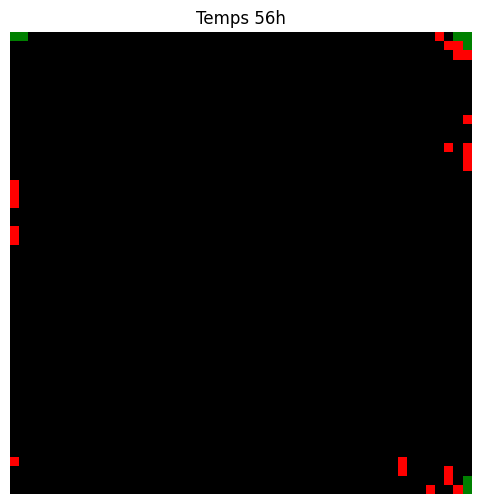

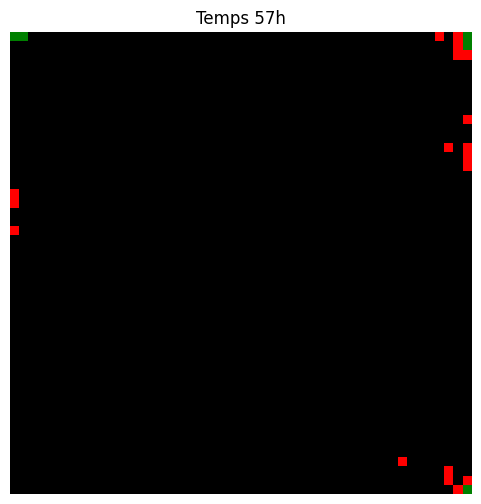

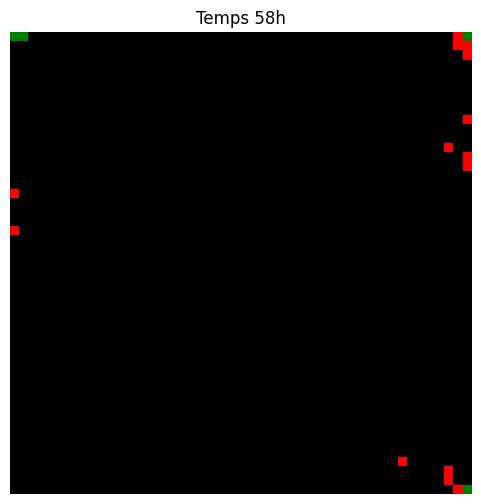

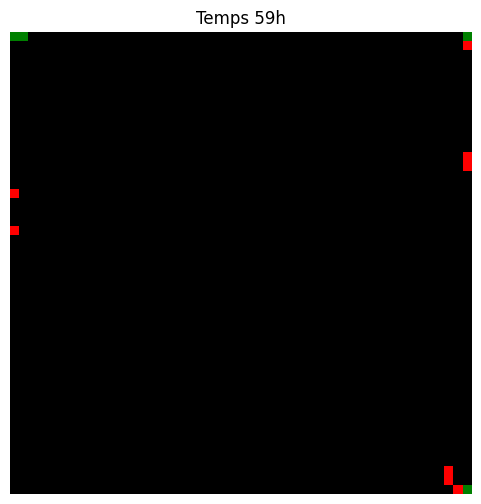

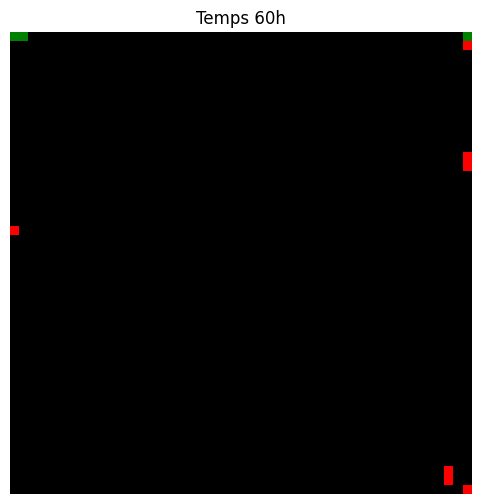

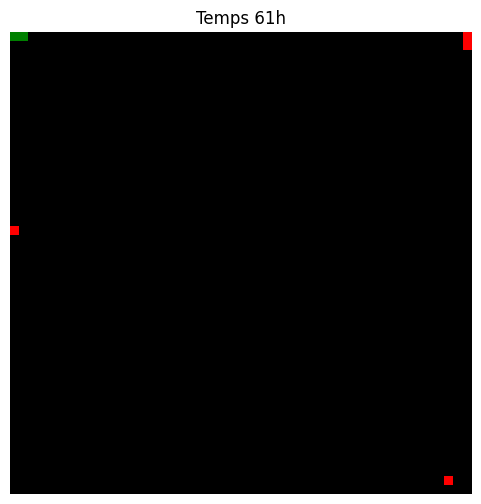

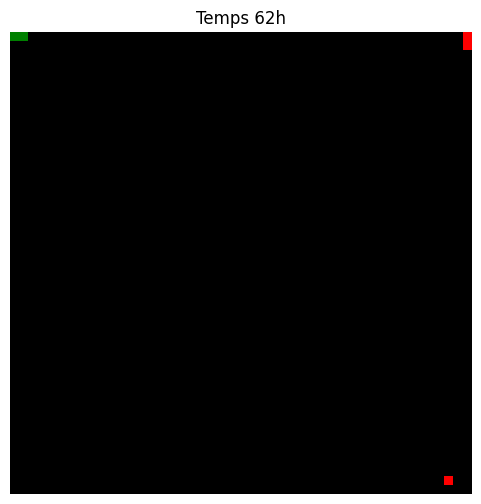

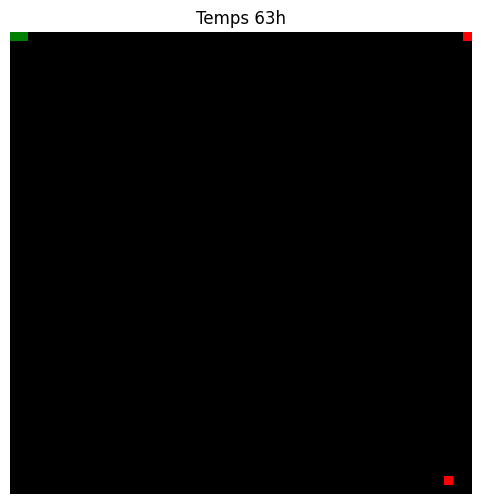

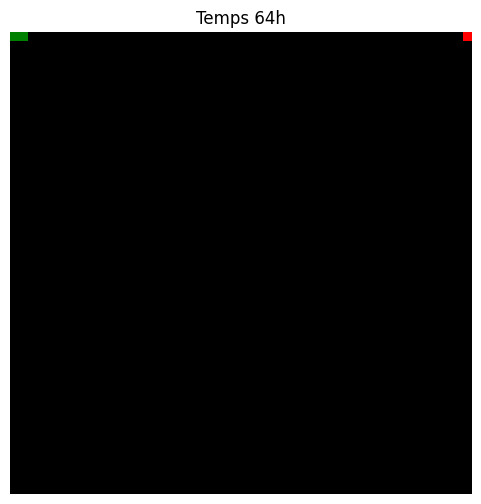

Incendi aturat per falta de propagació en 64 hores.


In [153]:
# === 4. Funció per visualitzar l'estat ===

import os

def plot_state(state, step, outdir="frames_novent"):
    os.makedirs(outdir, exist_ok=True)

    cmap = colors.ListedColormap(['green', 'red', 'black'])
    bounds = [-0.5, 0.5, 1.5, 2.5]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    plt.figure(figsize=(6, 6))
    plt.imshow(state, cmap=cmap, norm=norm)
    plt.title(f'Temps {step}h')
    plt.axis('off')

    fname = os.path.join(outdir, f"frame_{step:03d}.png")
    plt.savefig(fname)
    plt.show()  # Afegeix la visualització al notebook
    plt.close()

# === 5. Simulació ===
max_steps = 100
for step in range(max_steps):
    plot_state(state, step, outdir="frames_novent")
    next_state, next_humidity_timer, next_vegetation_timer = update_fire(state, humidity, vegetation, humidity_timer, vegetation_timer)

    # Comprovem si hi ha canvi
    if np.array_equal(next_state, state):
        print(f"Incendi aturat per falta de propagació en {step} hores.")
        break

    state = next_state
    humidity_timer = next_humidity_timer
    vegetation_timer = next_vegetation_timer


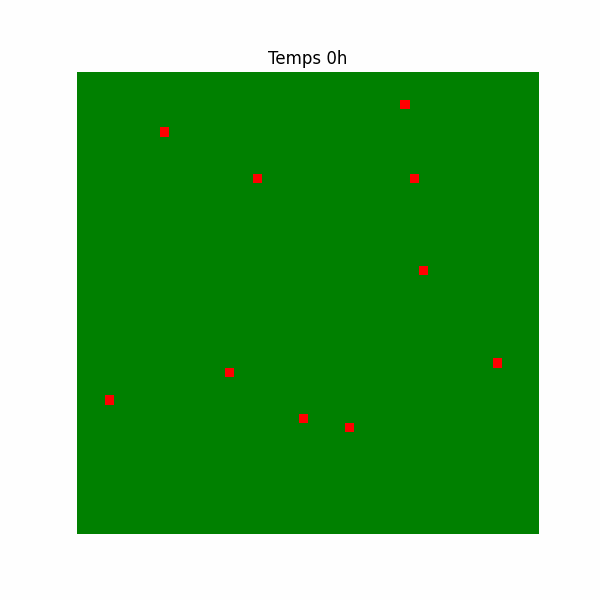

In [154]:
make_gif("frames_novent", "incendi_sense_vent.gif")

PART OPTATIVA: vent

Si el veí està a la direcció del vent, augmentem el comptador de humitat el doble (+2).

Si qualsevol altre veí està cremant, increment normal (+1).

Direcció del vent escollida: Nord-Oest (↖)


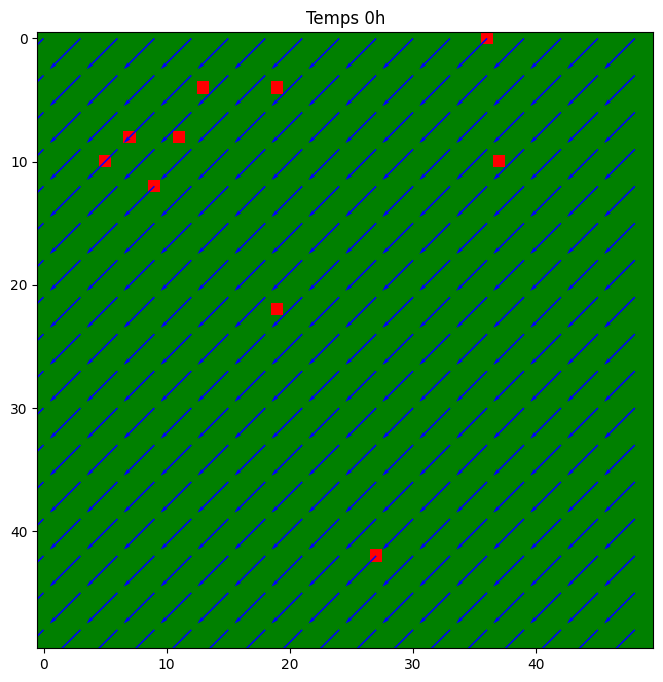

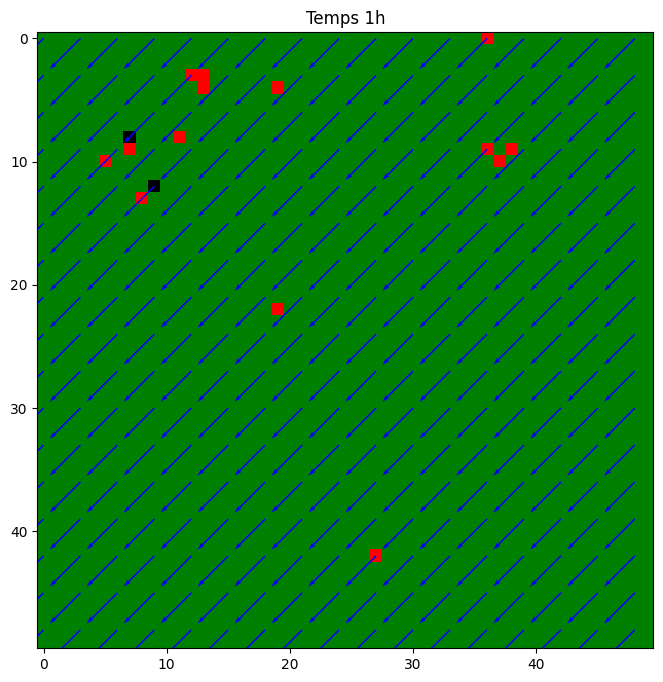

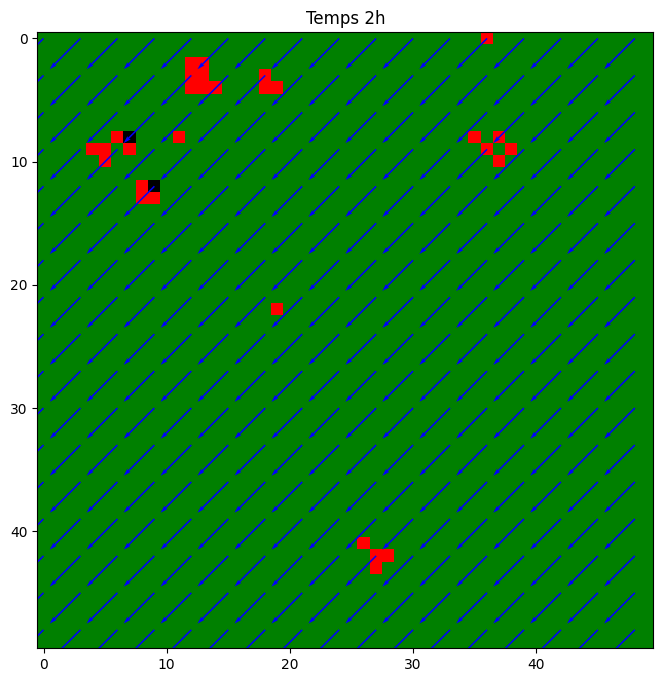

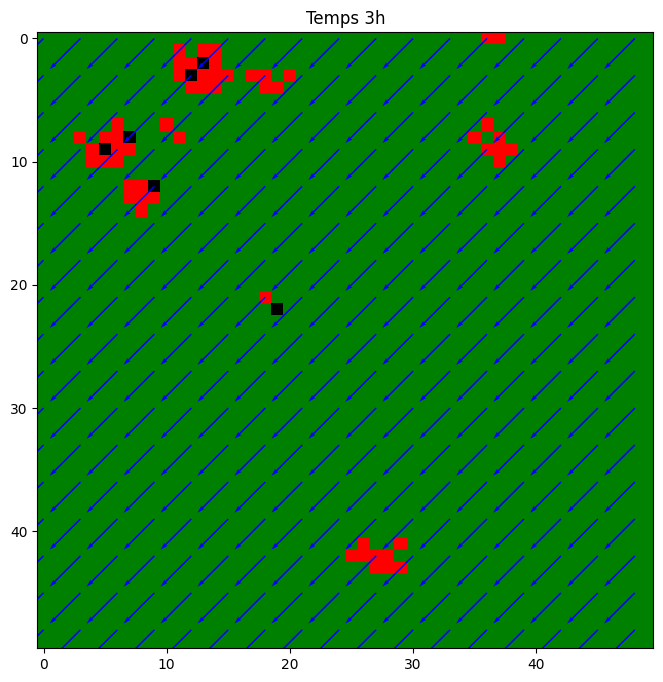

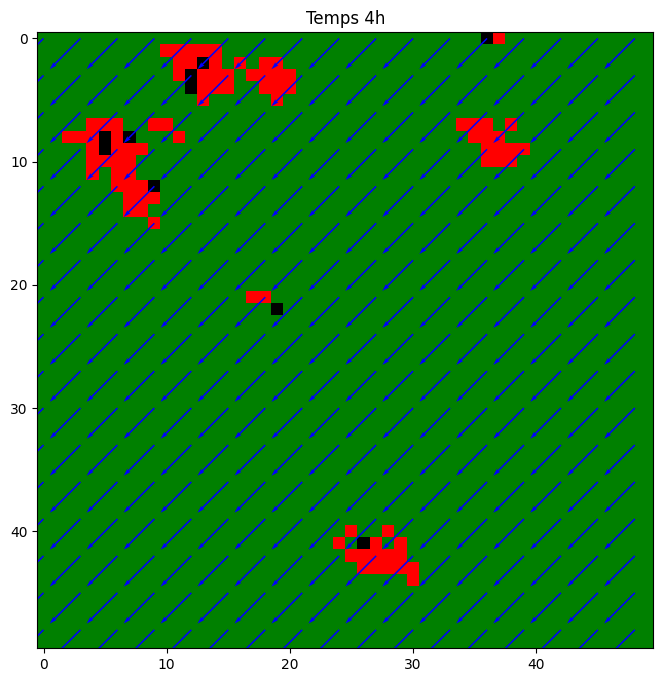

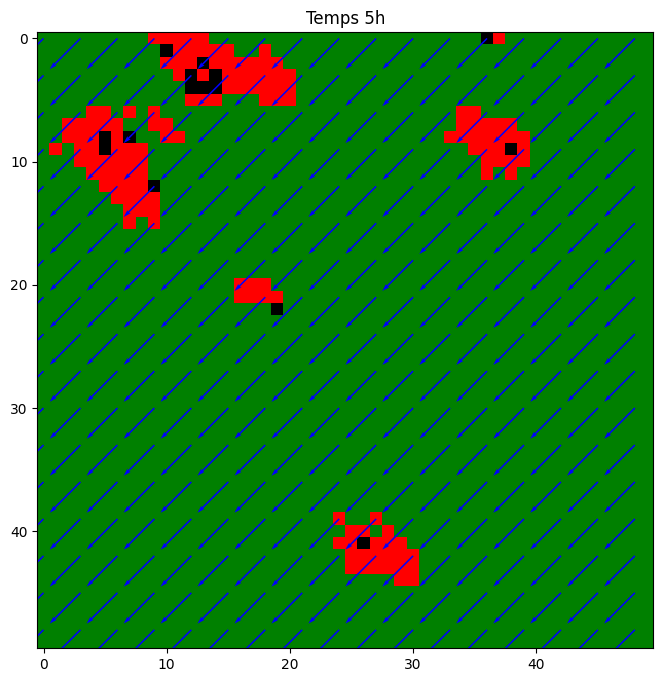

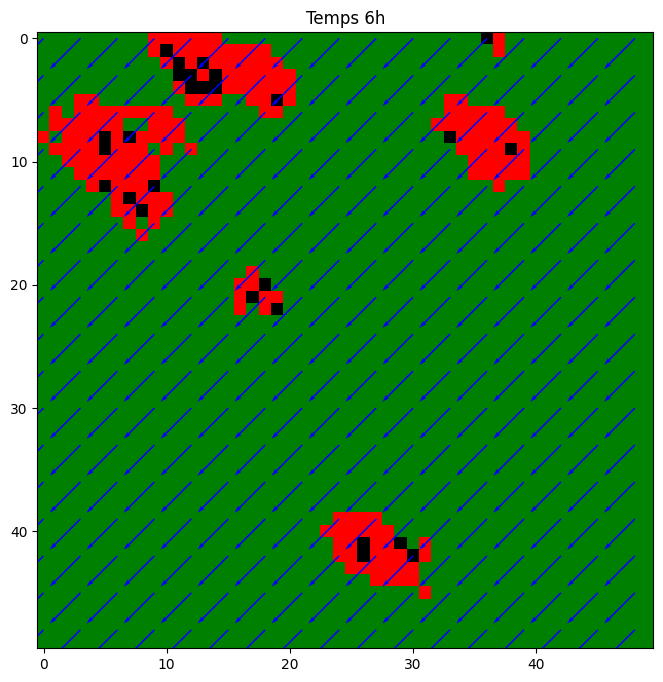

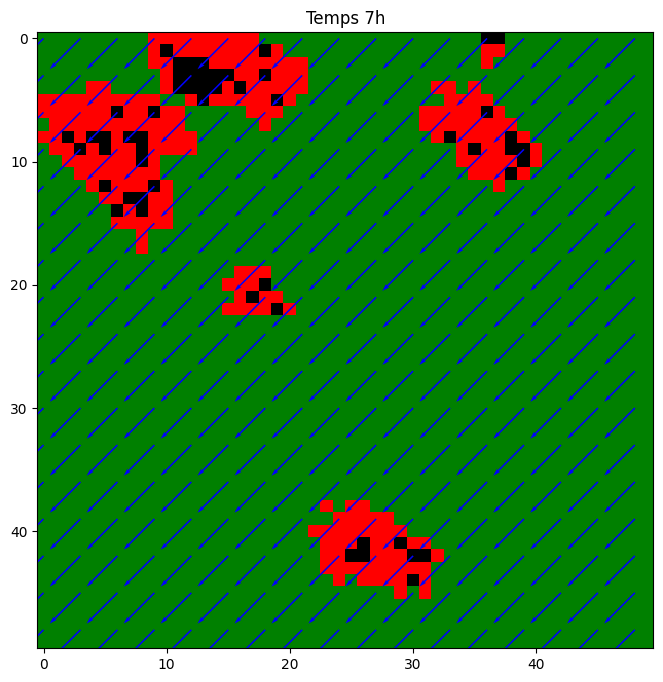

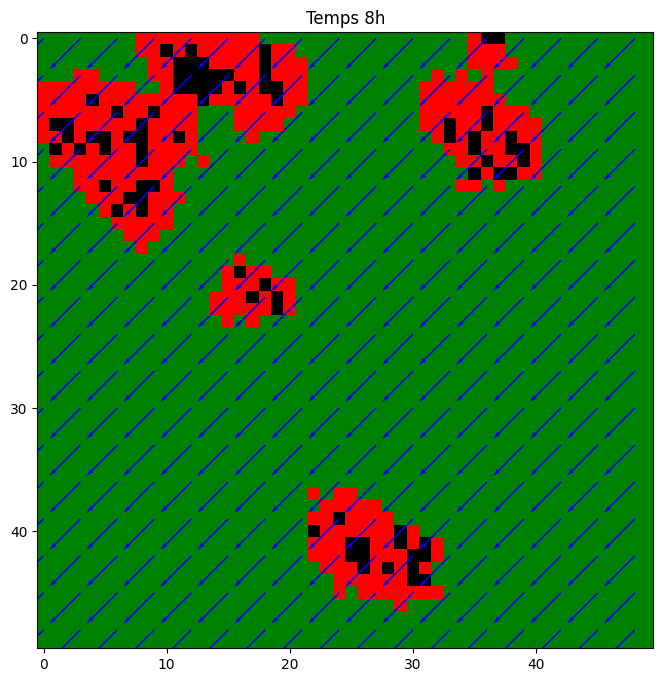

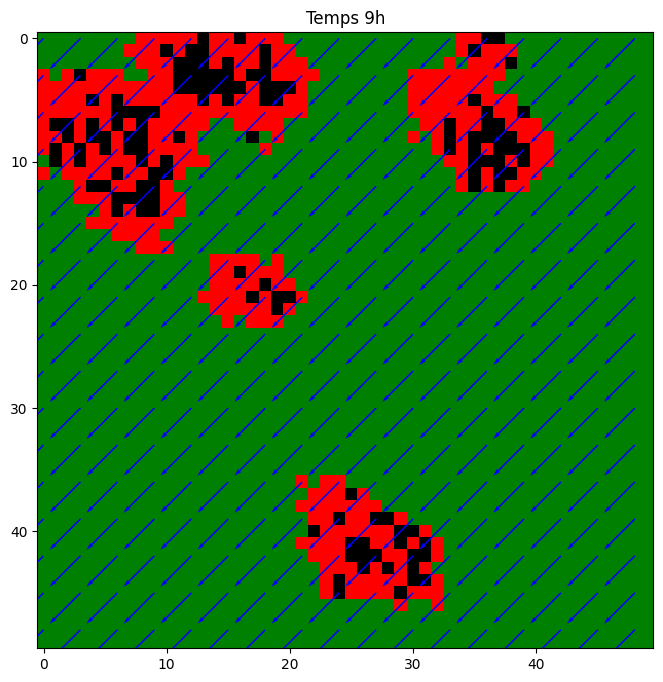

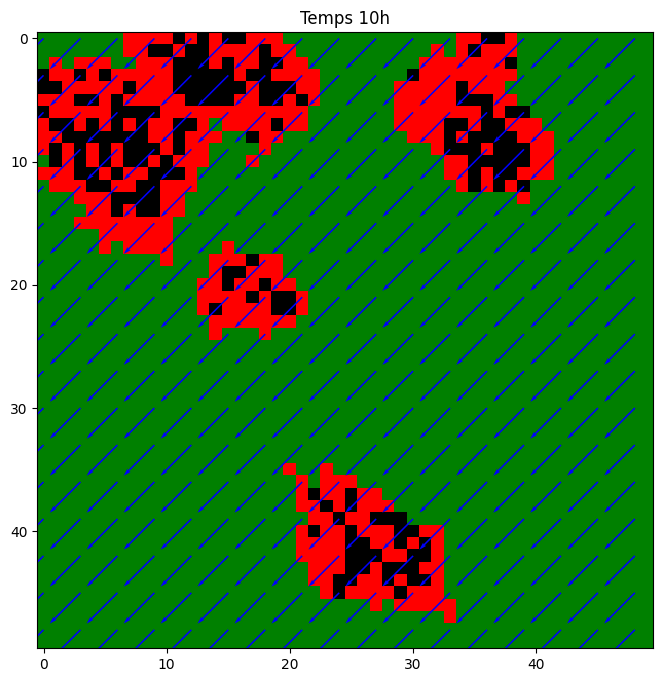

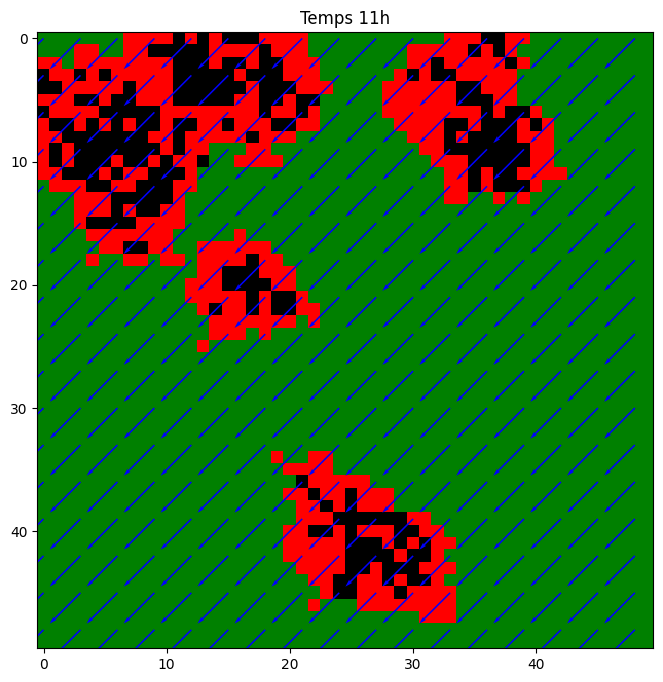

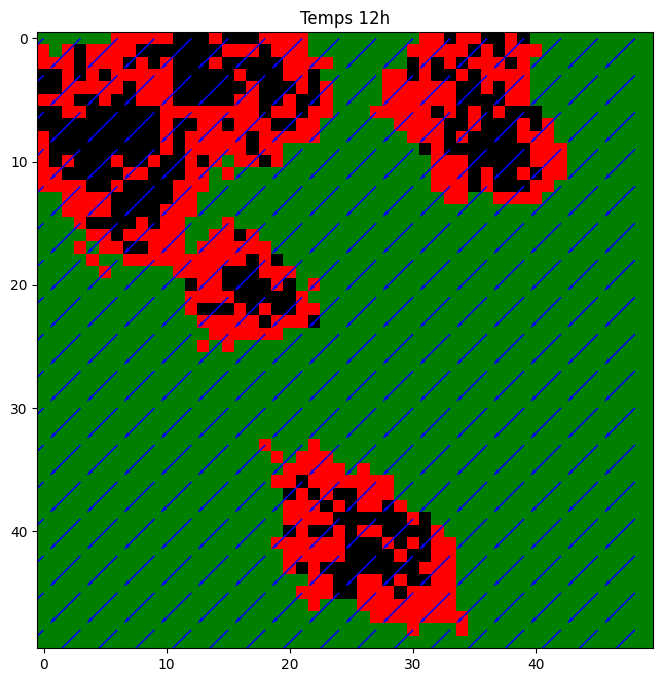

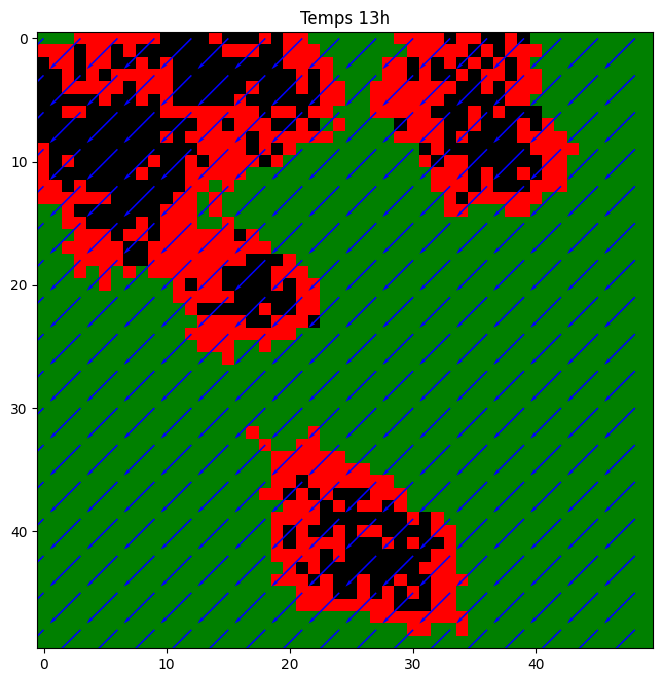

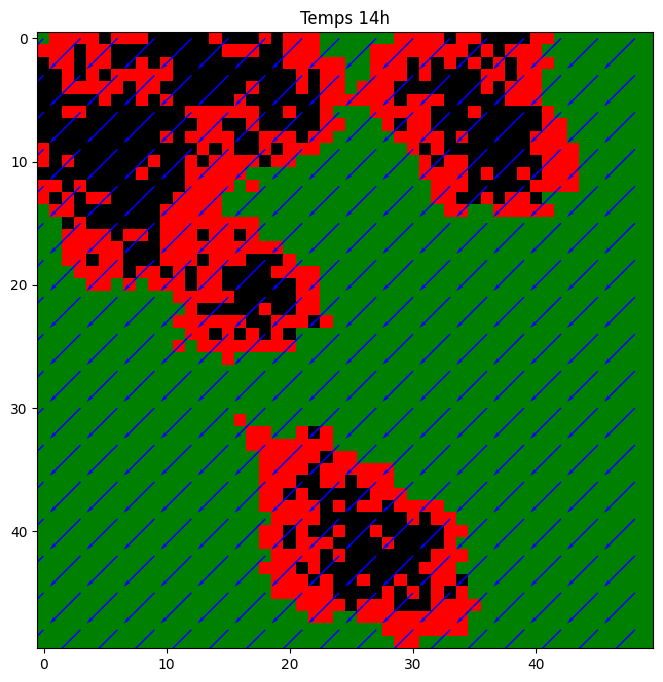

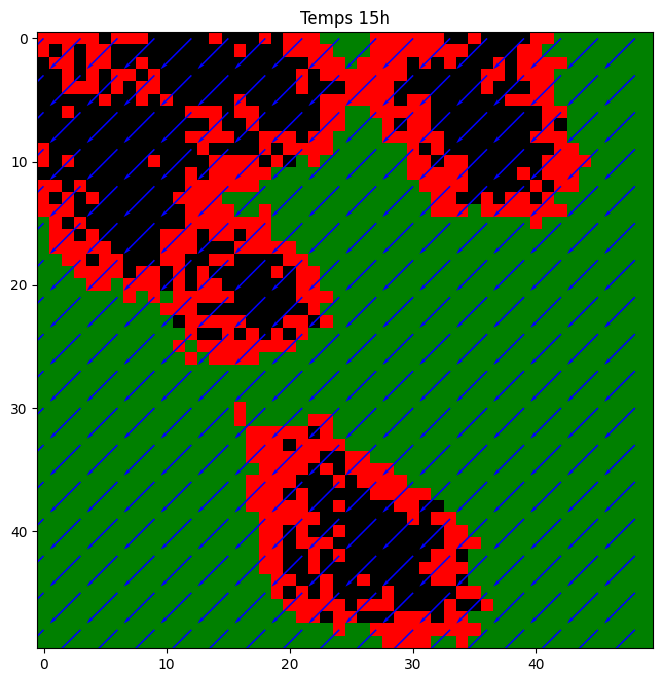

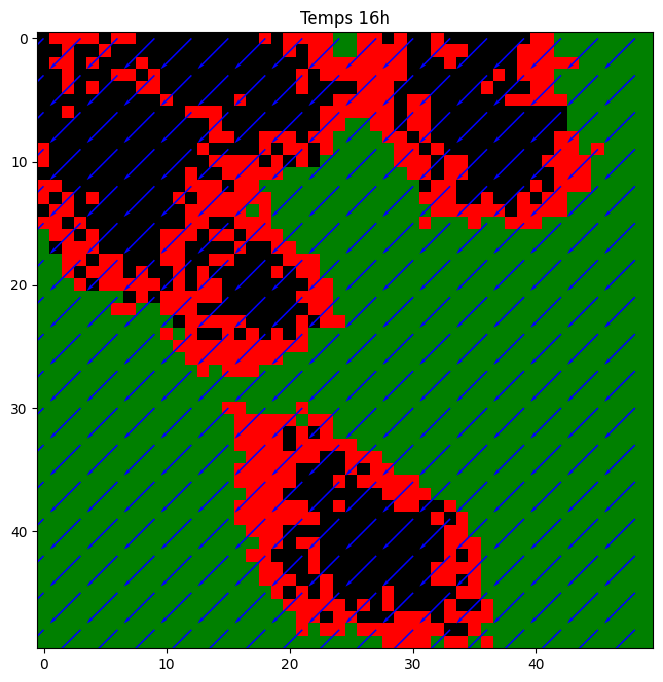

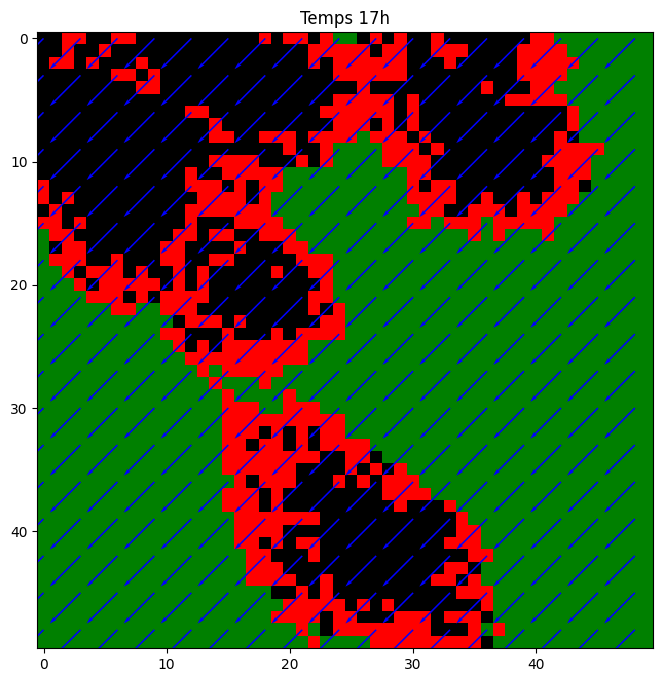

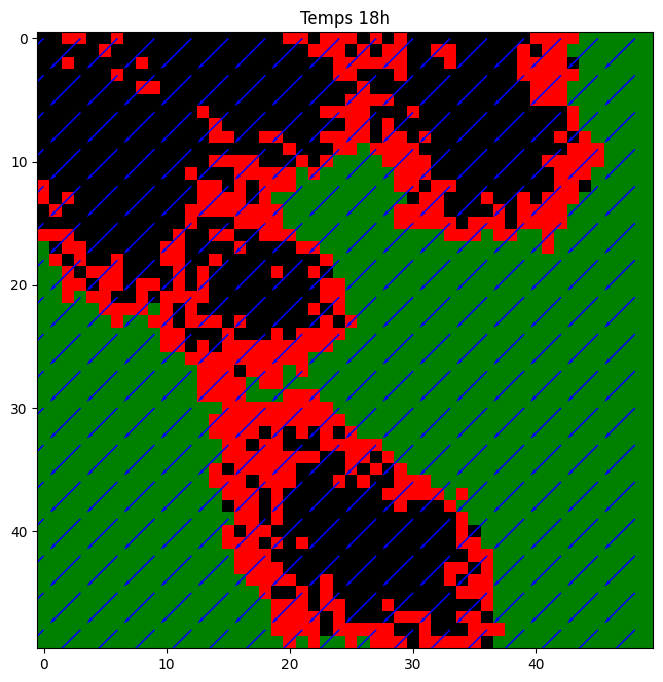

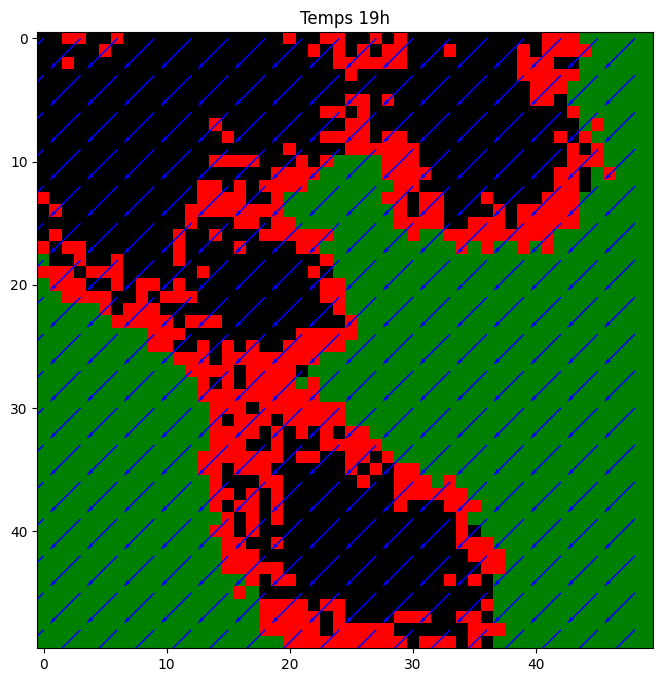

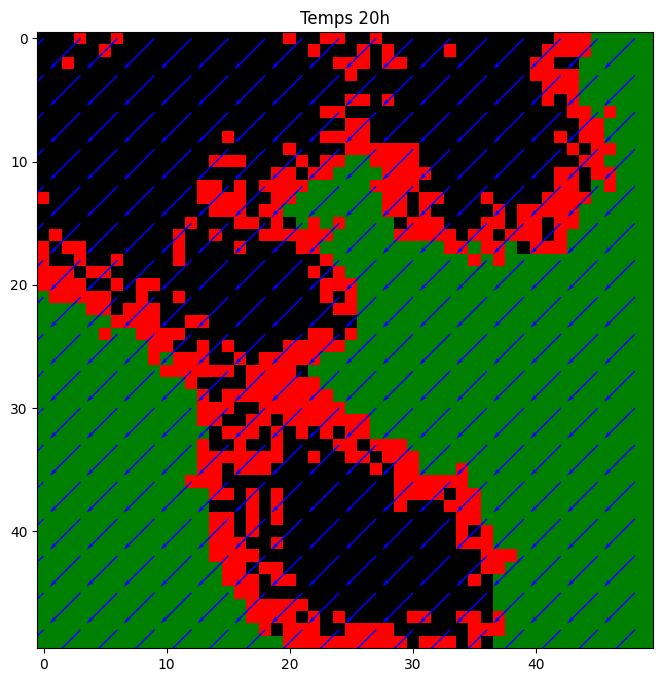

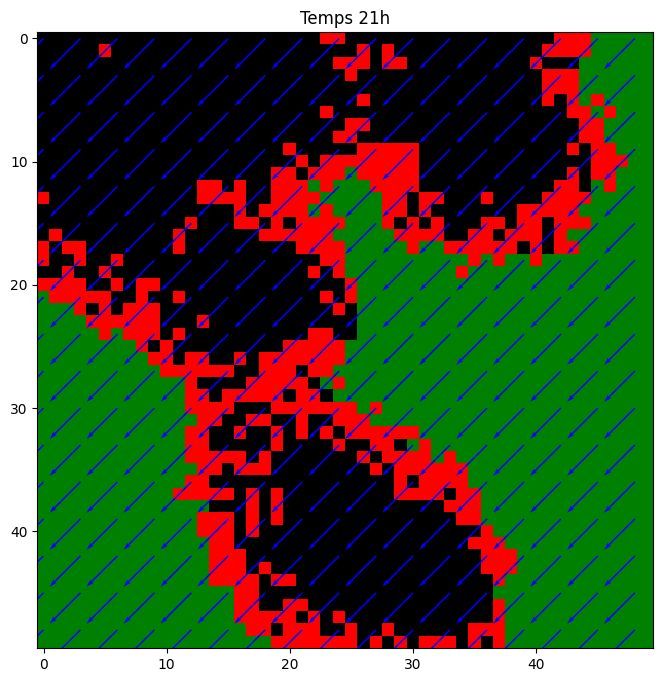

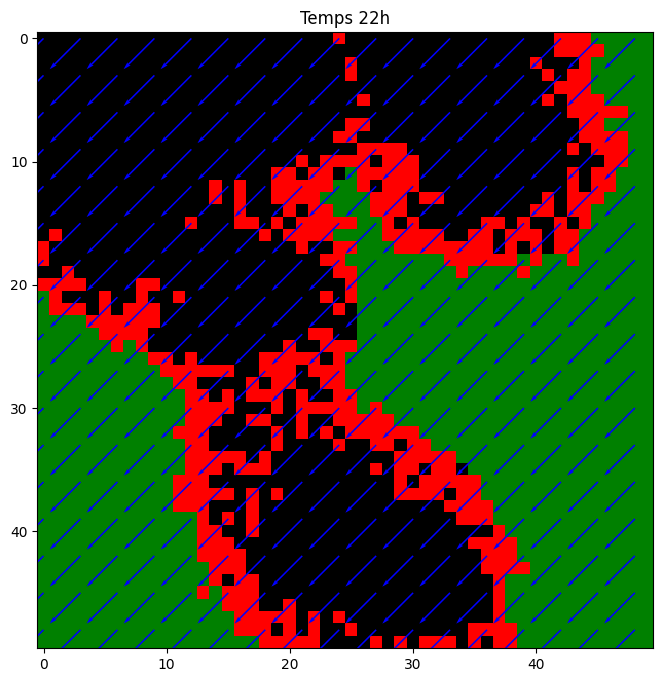

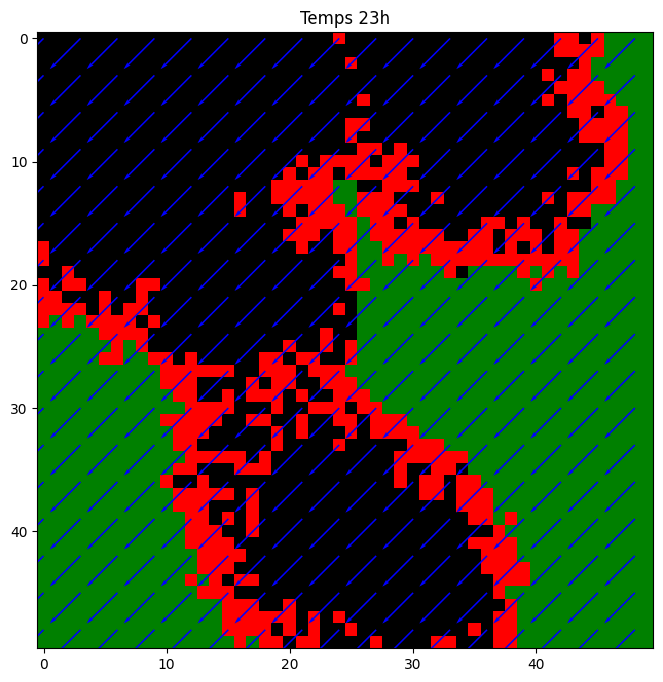

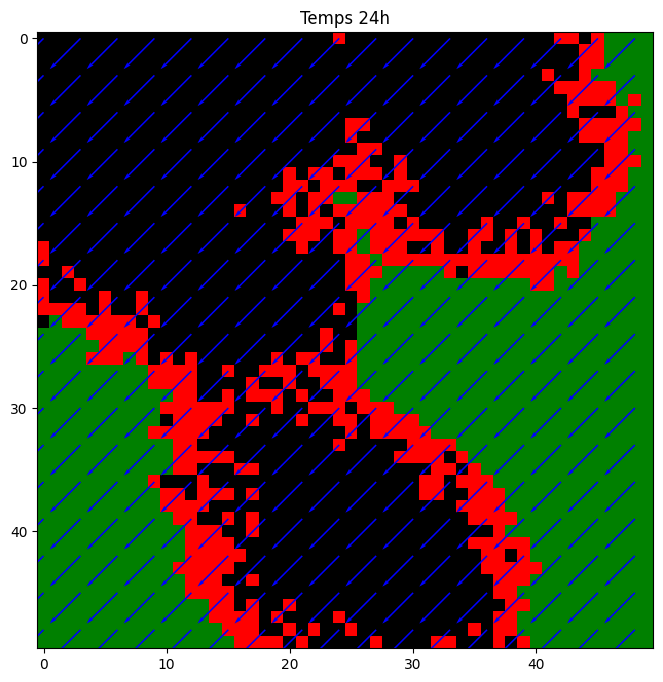

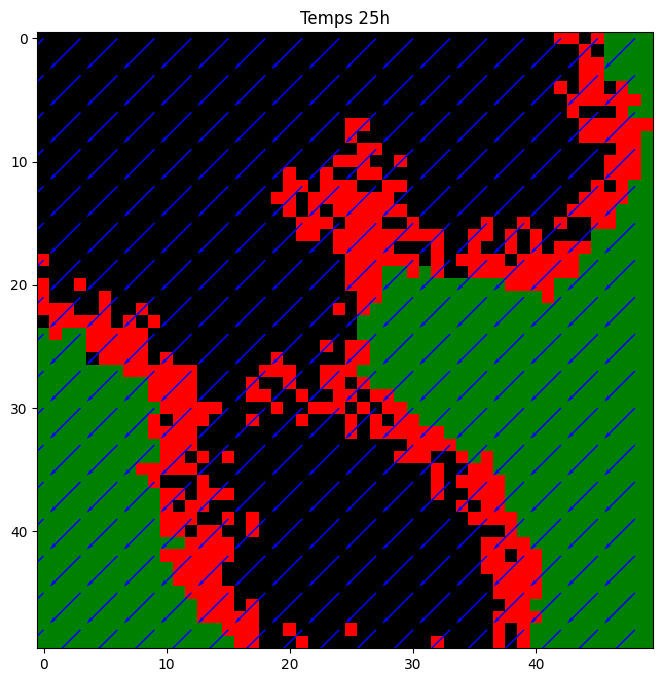

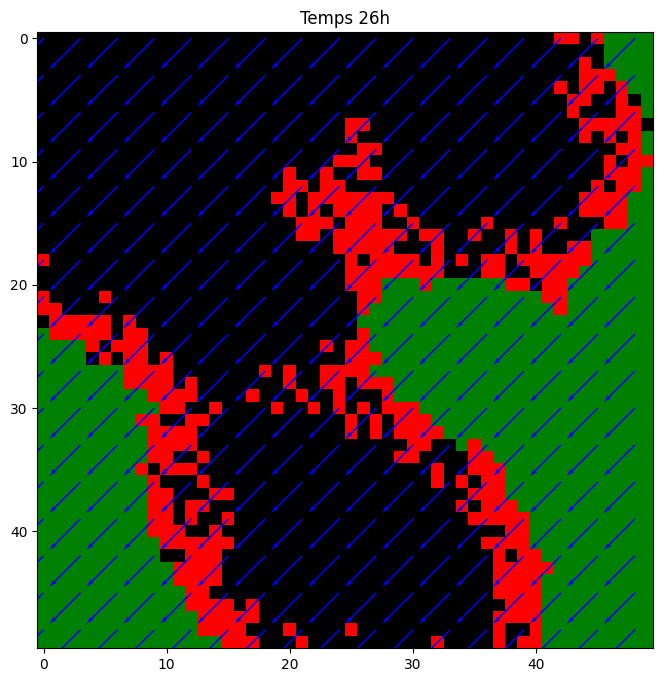

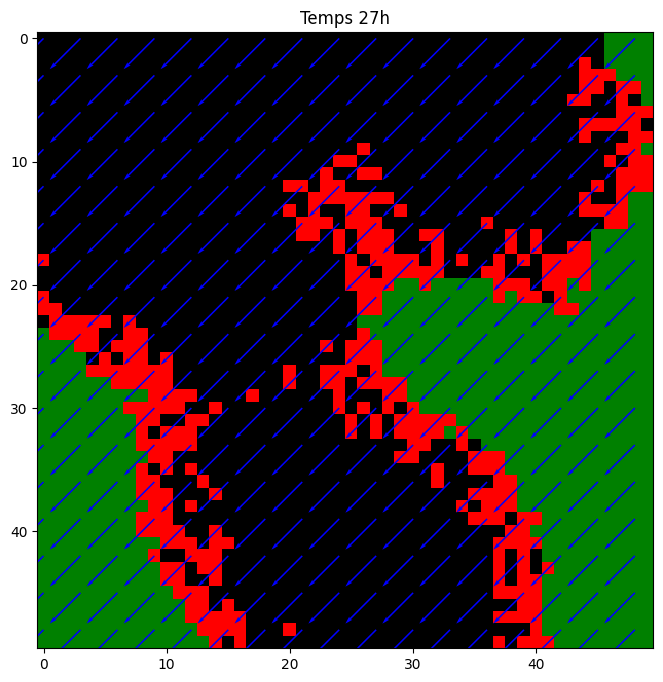

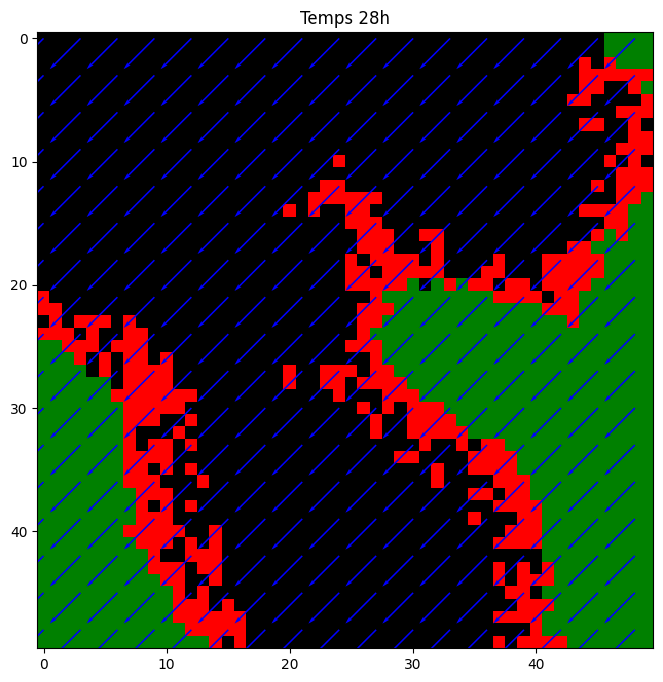

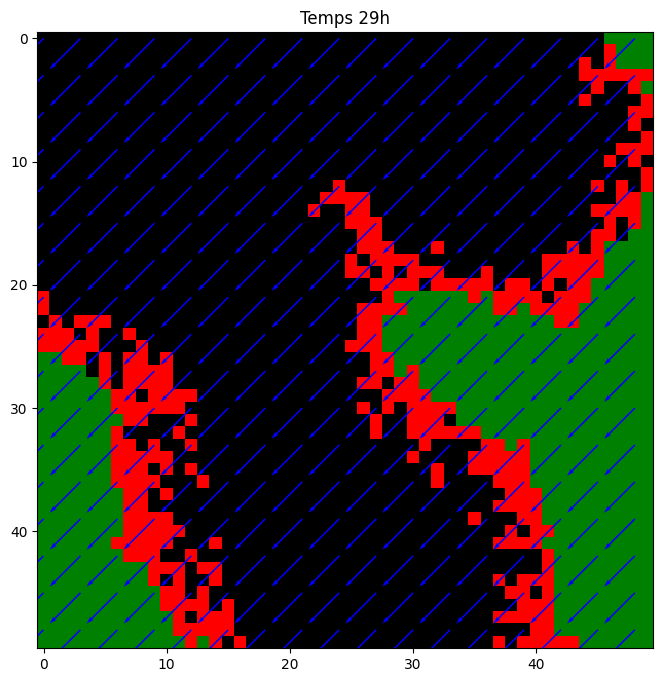

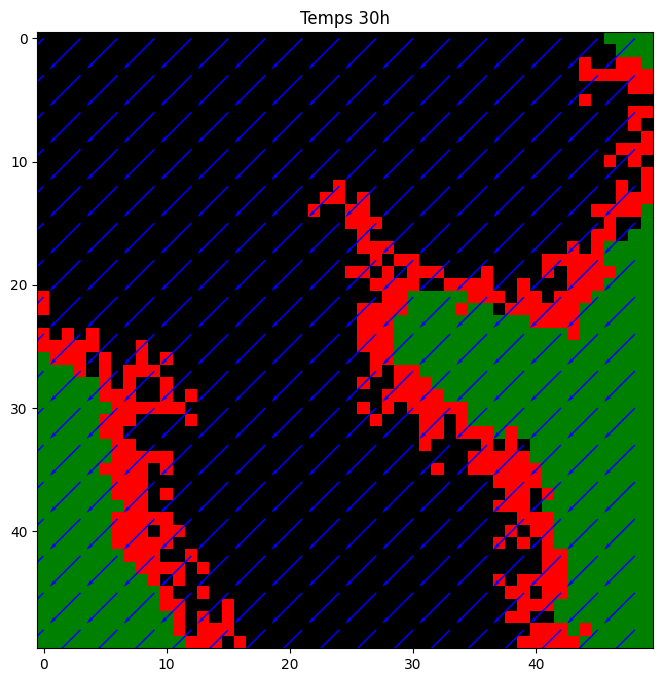

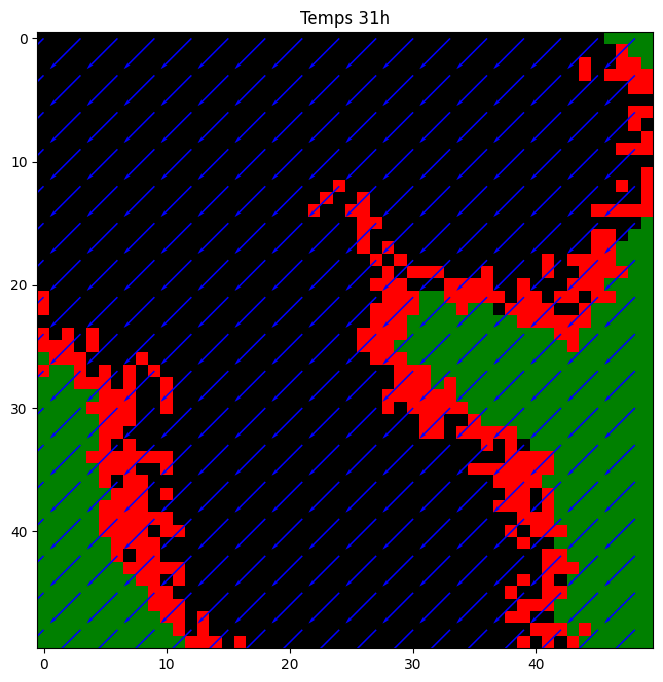

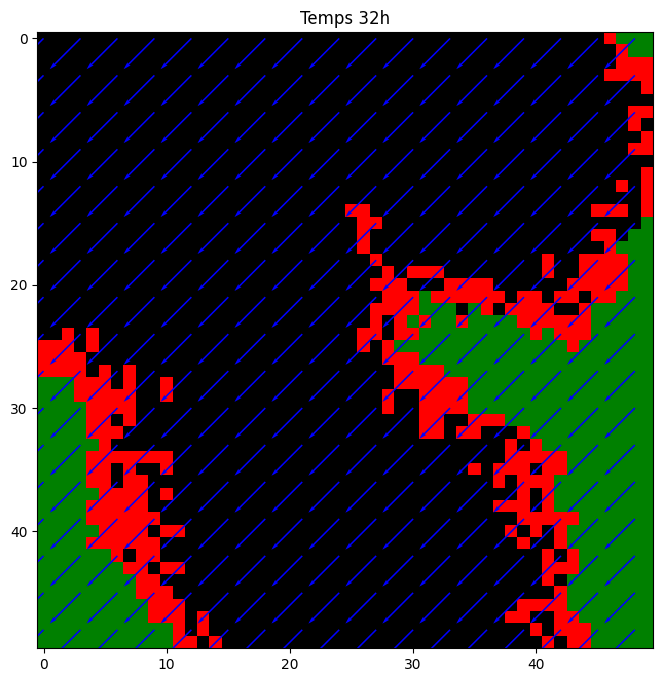

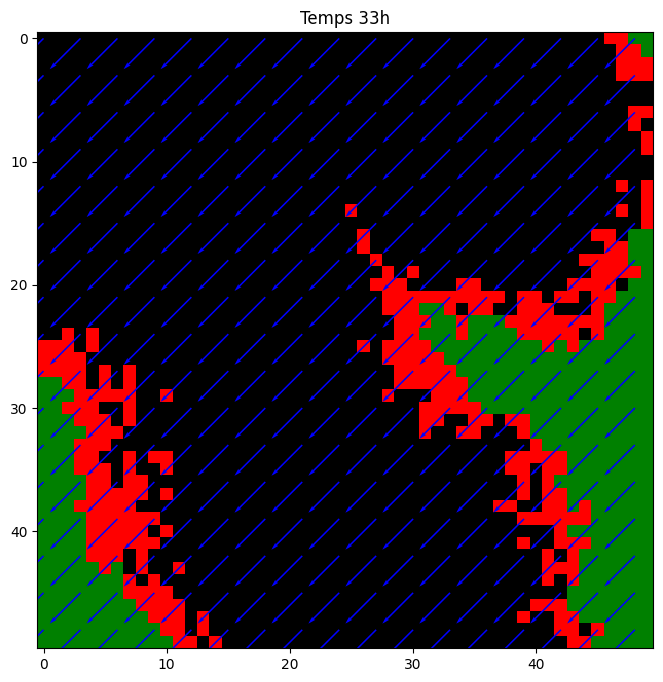

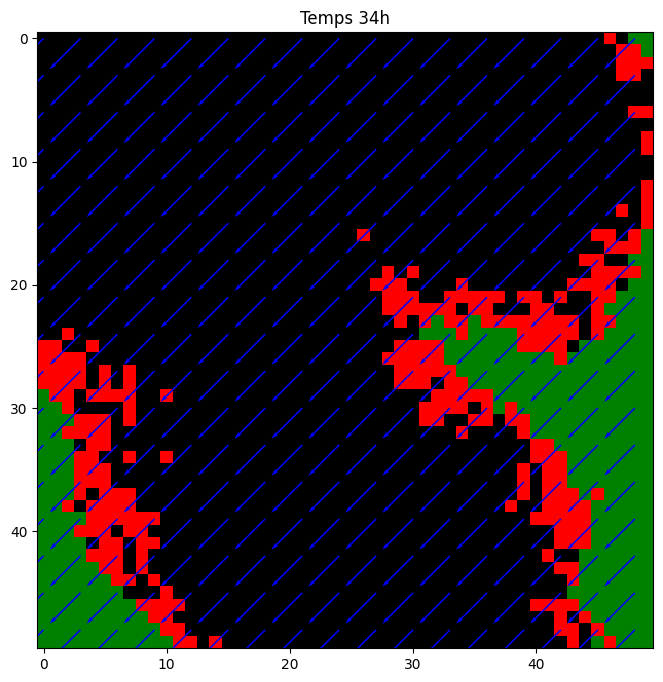

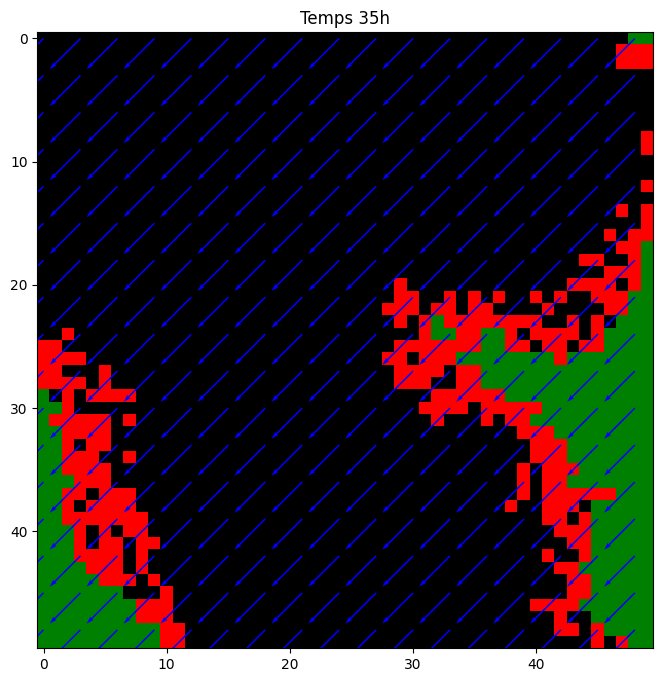

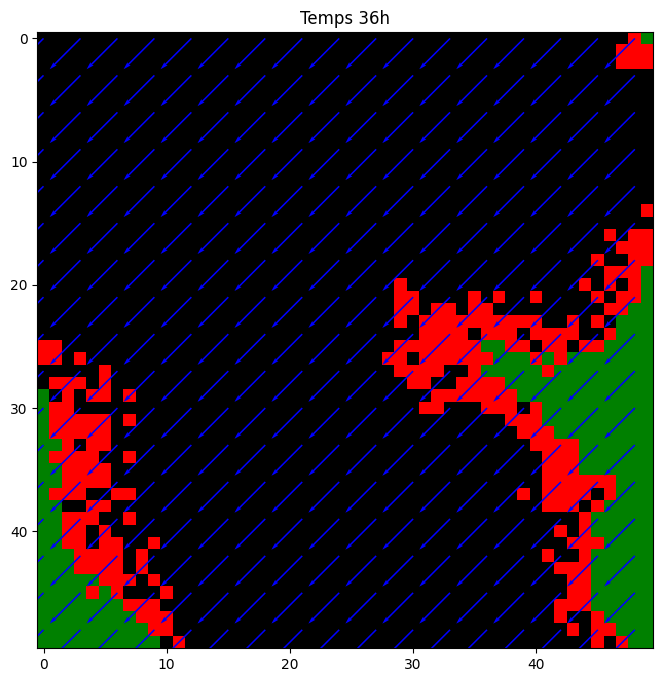

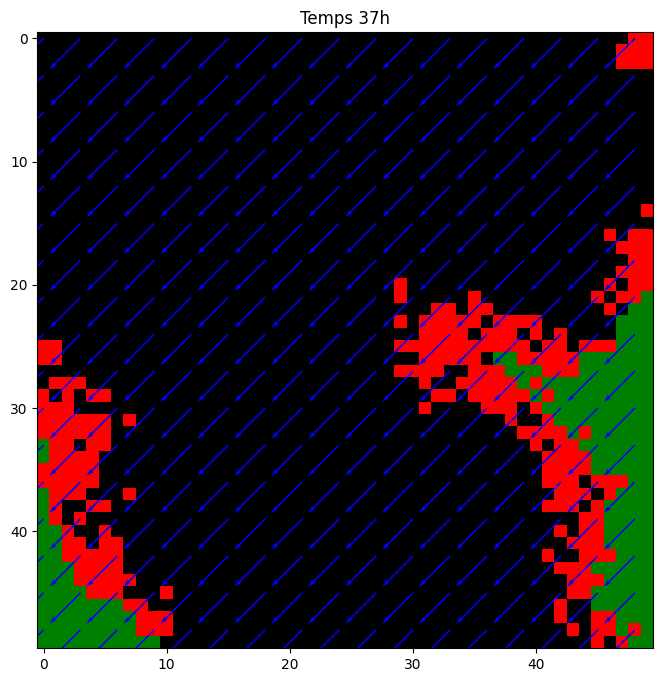

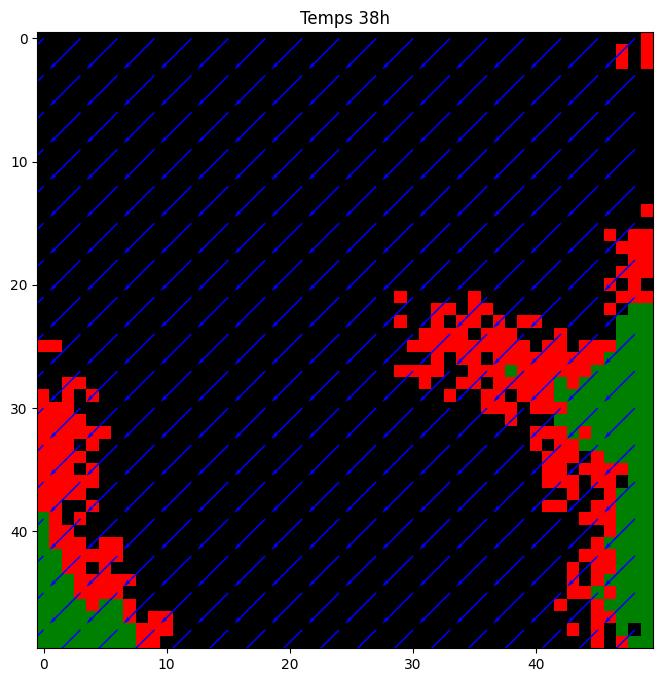

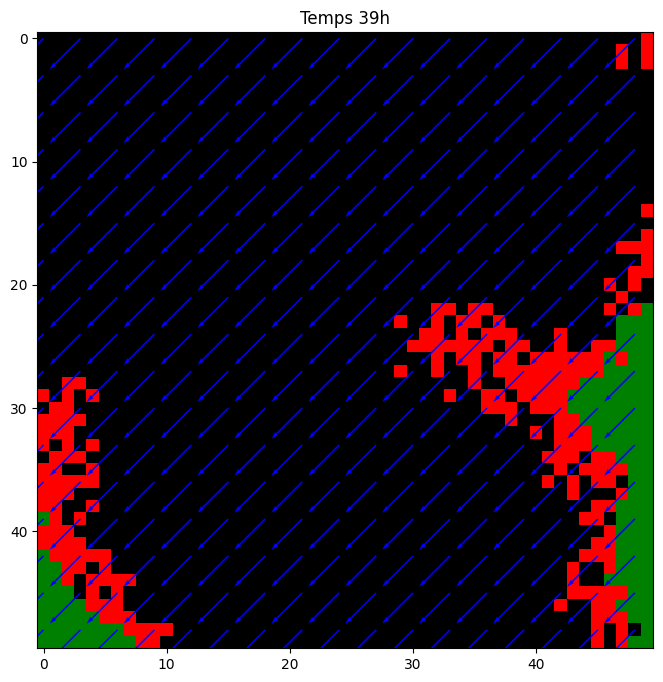

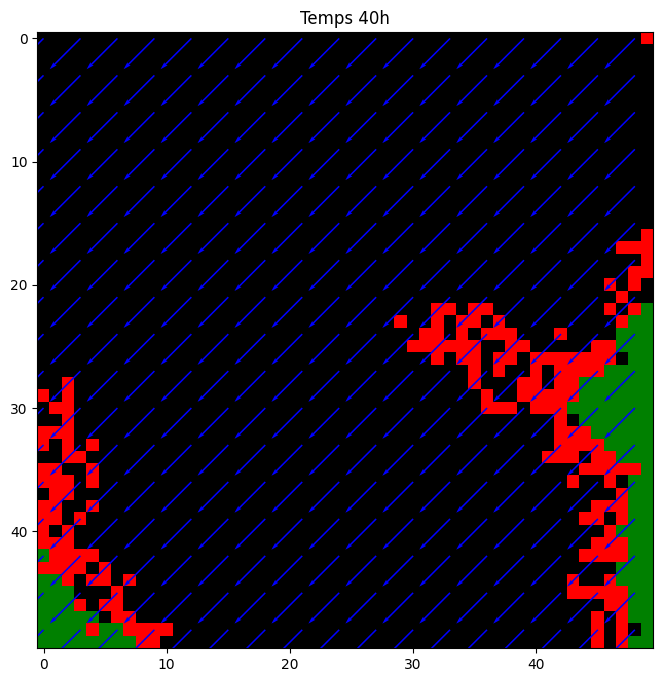

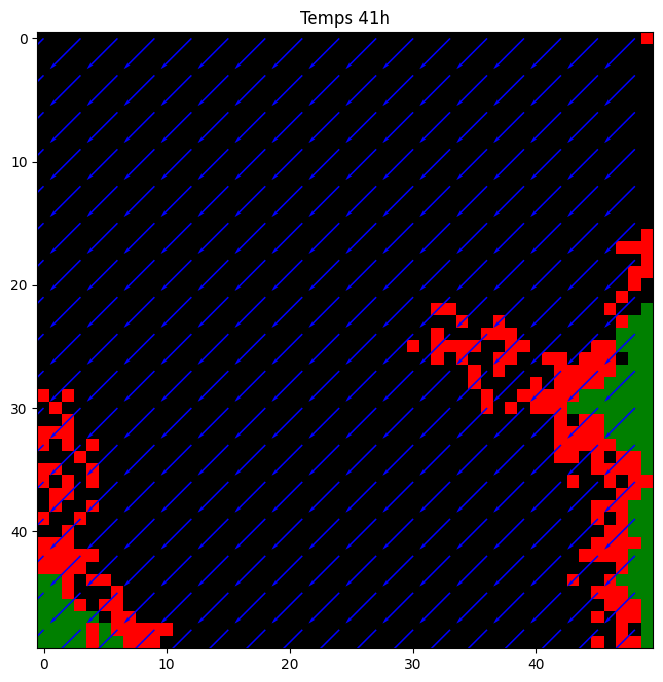

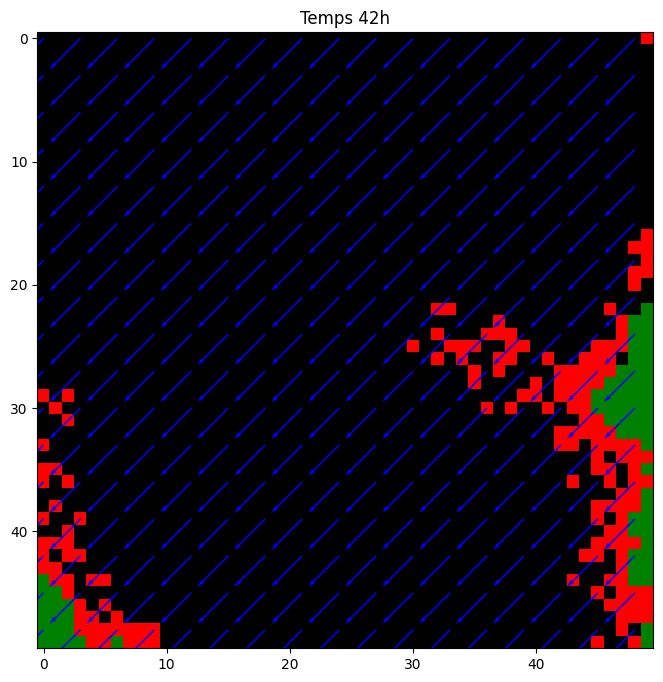

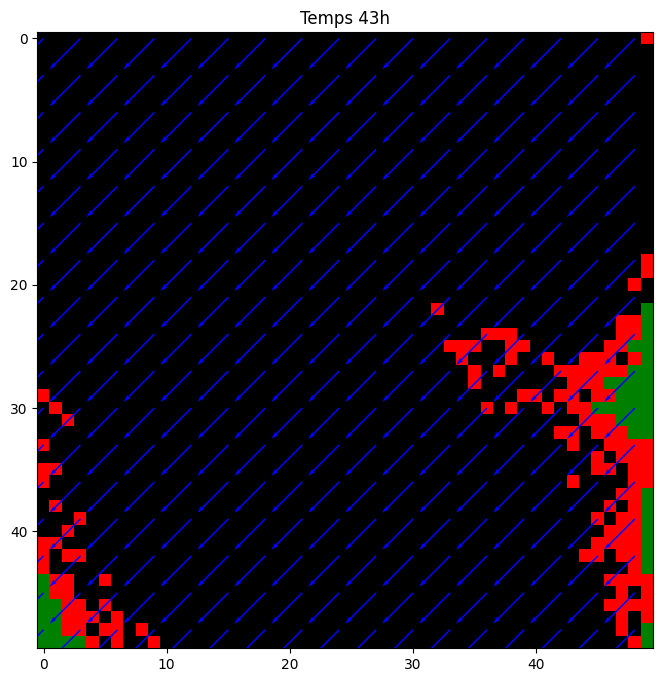

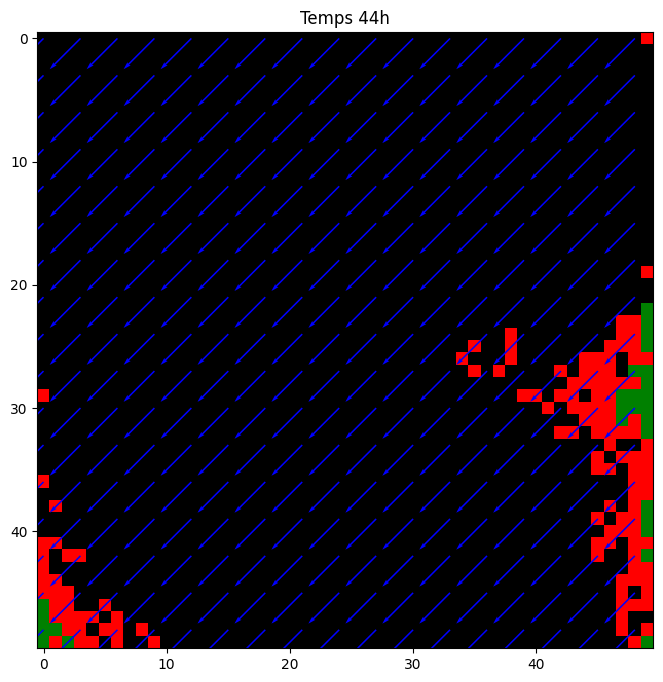

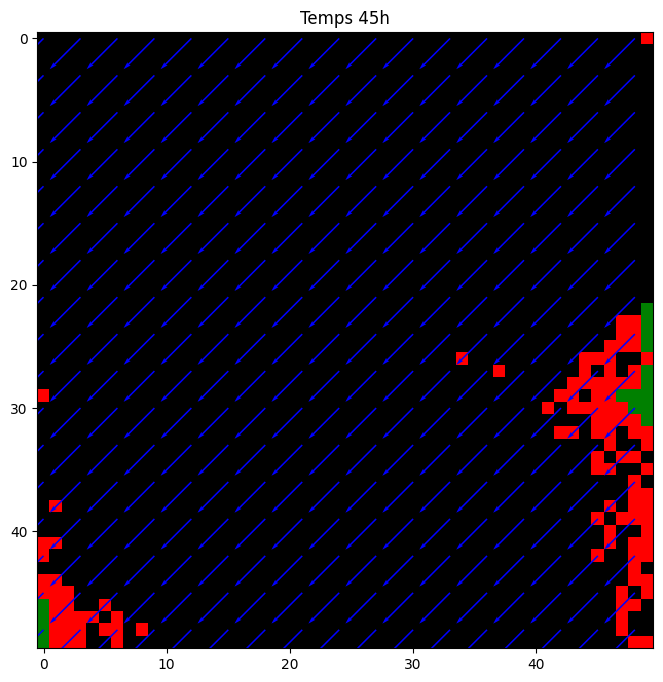

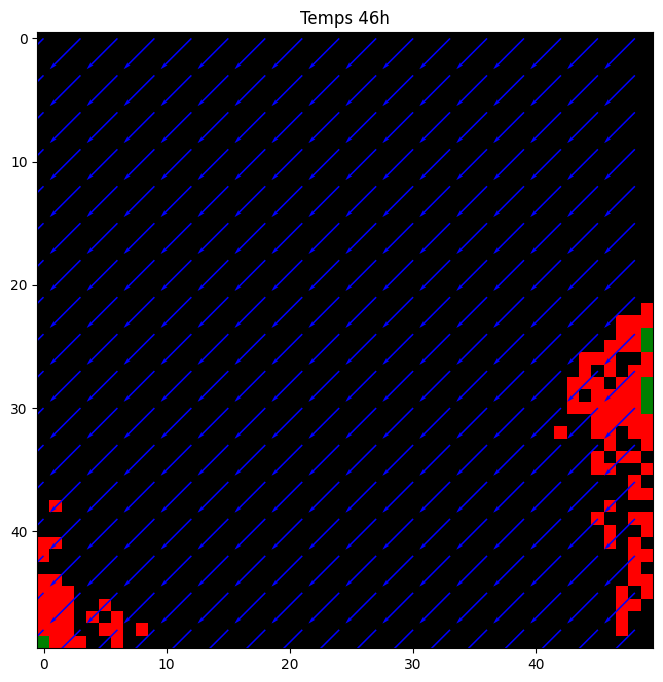

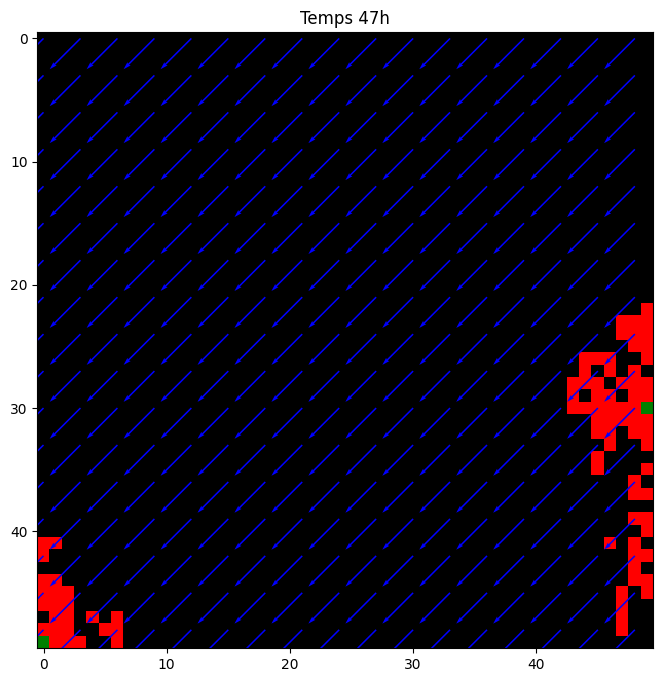

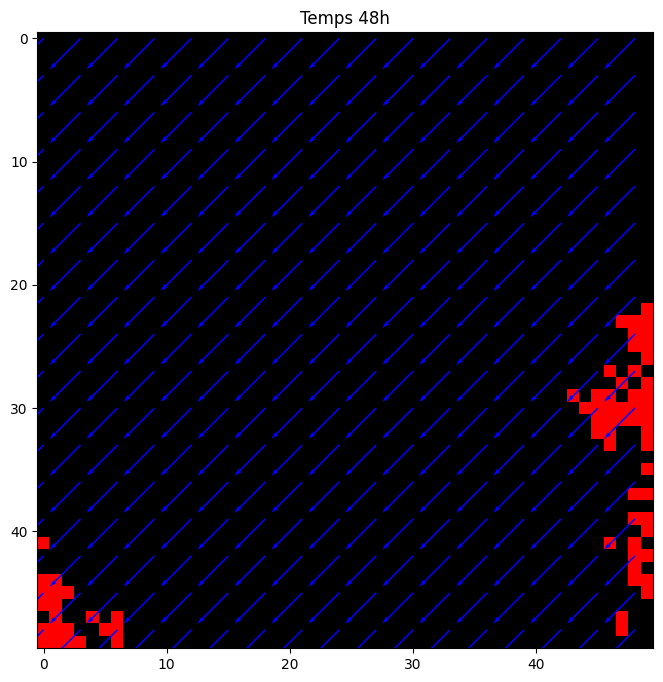

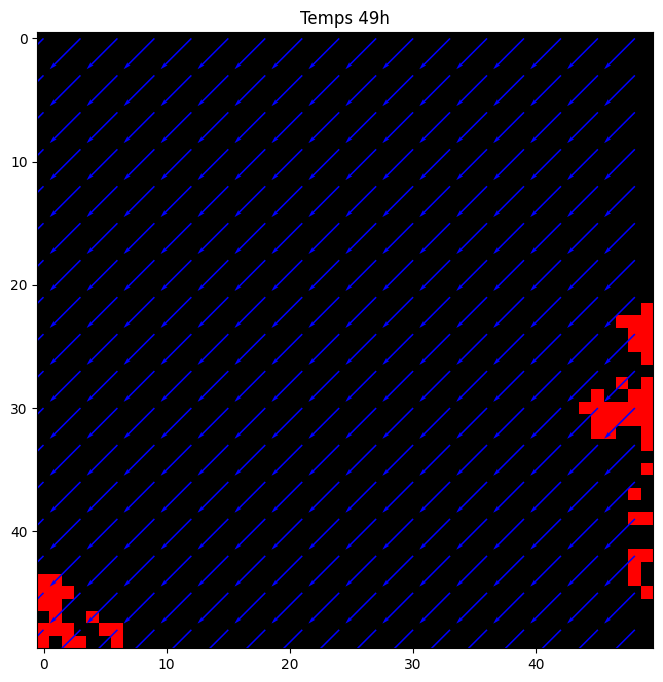

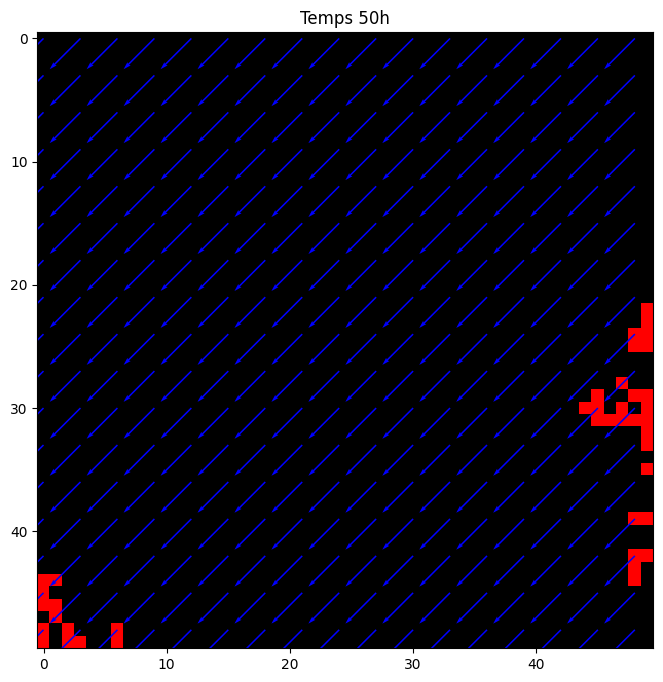

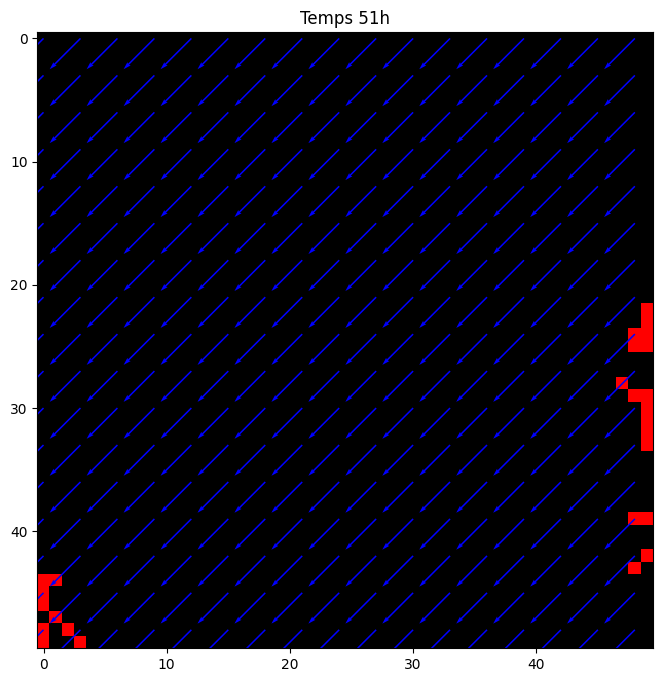

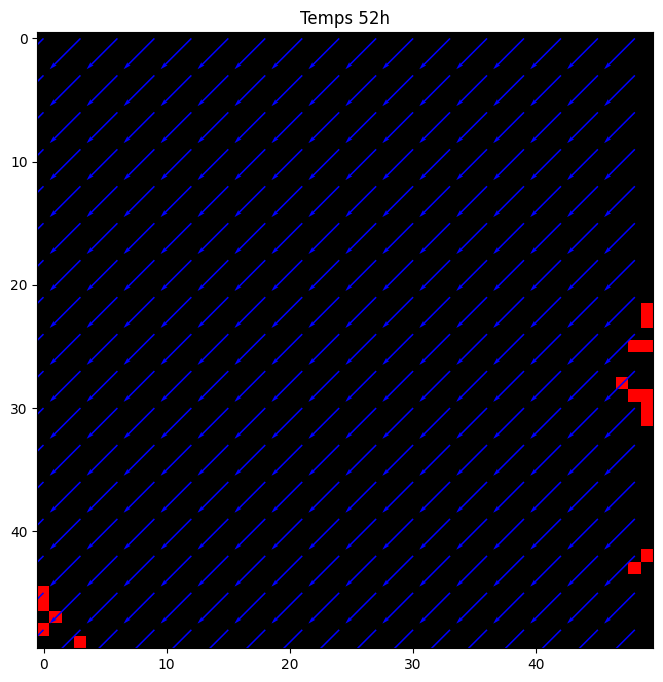

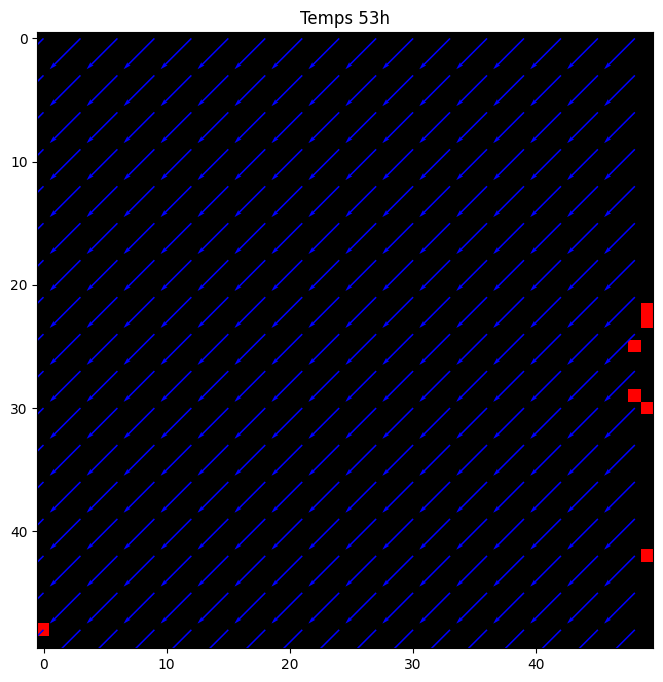

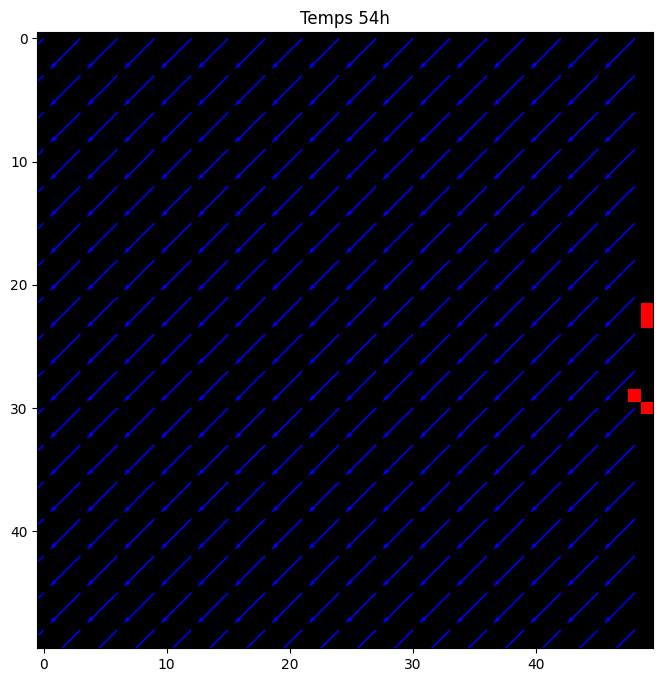

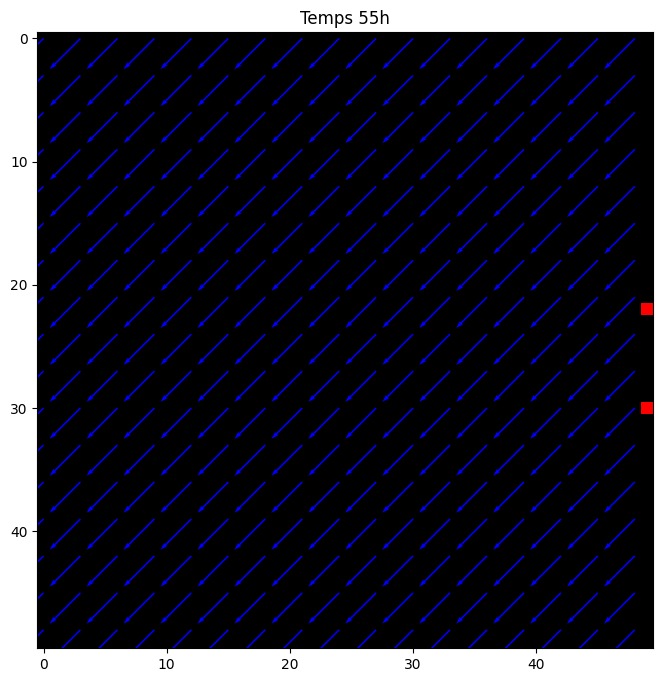

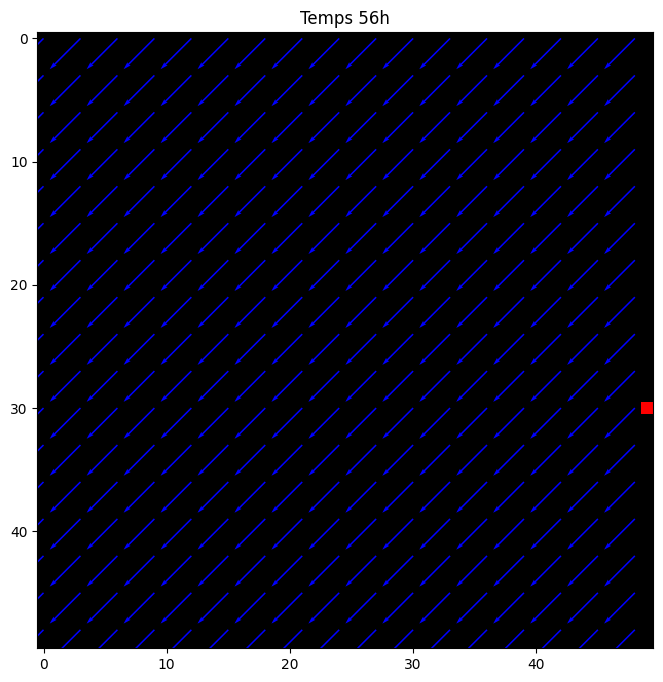

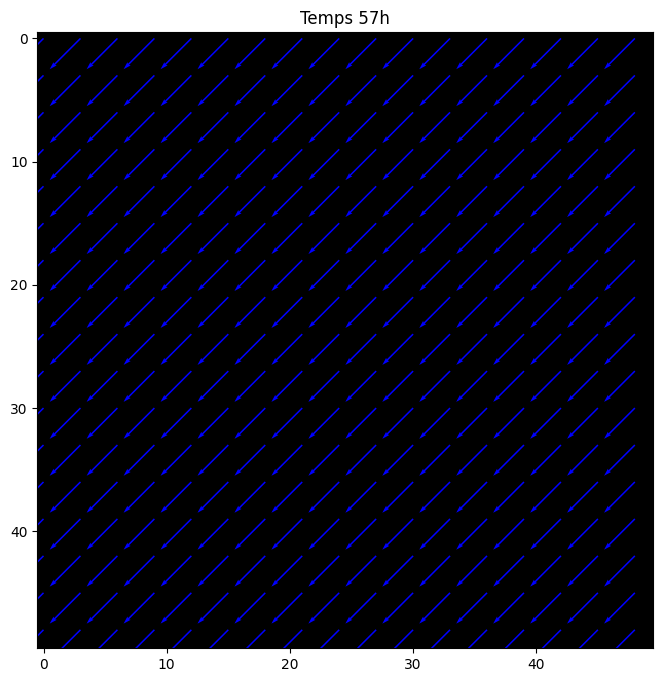

Incendi aturat per falta de propagació en 57 hores.


In [155]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

# === 1. Funció per llegir fitxers .img (IDRISI32) ===
def read_img(path, shape):
    with open(path, 'rb') as f:
        data = np.fromfile(f, dtype=np.int16)
    return data.reshape(shape)

# === 2. Inicialització ===

shape = (50, 50)

# Carreguem les capes
vegetation = read_img('vegetation.img', shape)
humidity = read_img('humidity.img', shape)

# Escollim direcció de vent global aleatòriament
wind_directions = {
    0: "Nord (↑)",
    1: "Nord-Est (↗)",
    2: "Est (→)",
    3: "Sud-Est (↘)",
    4: "Sud (↓)",
    5: "Sud-Oest (↙)",
    6: "Oest (←)",
    7: "Nord-Oest (↖)"
}
chosen_wind_dir = np.random.randint(0, 8)
wind = np.full(shape, chosen_wind_dir, dtype=np.int16)
print(f"Direcció del vent escollida: {wind_directions[chosen_wind_dir]}")

# Estat de les cel·les: 0 = pendent, 1 = cremant, 2 = cremat
state = np.zeros(shape, dtype=int)

# Inicialitzem foc en diversos punts aleatoris
num_initial_fires = 10
initial_fire_coords = np.random.choice(np.arange(shape[0]*shape[1]), num_initial_fires, replace=False)
for idx in initial_fire_coords:
    i, j = divmod(idx, shape[1])
    state[i, j] = 1

# Capes auxiliars per controlar humitat i vegetació cremant
humidity_timer = np.zeros_like(humidity)
vegetation_timer = np.zeros_like(vegetation)

# === 3. Nova funció d'actualització del foc amb VENT DES DE CEL·LA CREMANT ===
def update_fire(state, humidity, vegetation, humidity_timer, vegetation_timer, wind):
    new_state = state.copy()
    new_humidity_timer = humidity_timer.copy()
    new_vegetation_timer = vegetation_timer.copy()

    directions = [(-1,0), (-1,1), (0,1), (1,1), (1,0), (1,-1), (0,-1), (-1,-1)]

    for i in range(state.shape[0]):
        for j in range(state.shape[1]):
            if state[i, j] == 1:  # Cel·la que està cremant
                new_vegetation_timer[i, j] += 1
                if new_vegetation_timer[i, j] >= vegetation[i, j]:
                    new_state[i, j] = 2  # Ja està cremada

                wind_dir = wind[i, j]  # Direcció del vent a aquesta cel·la
                for d, (di, dj) in enumerate(directions):
                    ni, nj = i + di, j + dj
                    if 0 <= ni < state.shape[0] and 0 <= nj < state.shape[1]:
                        if new_state[ni, nj] == 0:
                            # Propagació amb impuls
                            if d == wind_dir:
                                new_humidity_timer[ni, nj] += 4  # Direcció del vent
                            else:
                                new_humidity_timer[ni, nj] += 1

                            # Si s'ha superat la humitat, encén la cel·la
                            if new_humidity_timer[ni, nj] >= humidity[ni, nj]:
                                new_state[ni, nj] = 1

    return new_state, new_humidity_timer, new_vegetation_timer

# === 4. Funció per visualitzar l'estat amb fletxes de vent ===
def plot_state_to_file_with_wind(state, step, wind, outdir="frames_ambvent"):
    os.makedirs(outdir, exist_ok=True)

    cmap = colors.ListedColormap(['green', 'red', 'black'])
    bounds = [-0.5, 0.5, 1.5, 2.5]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    plt.figure(figsize=(8, 8))
    plt.imshow(state, cmap=cmap, norm=norm)
    plt.title(f'Temps {step}h')

    direction_vectors = {
        0: (-1, 0),  # Nord
        1: (-1, 1),  # Nord-Est
        2: (0, 1),   # Est
        3: (1, 1),   # Sud-Est
        4: (1, 0),   # Sud
        5: (1, -1),  # Sud-Oest
        6: (0, -1),  # Oest
        7: (-1, -1)  # Nord-Oest
    }

    X, Y = np.meshgrid(np.arange(state.shape[1]), np.arange(state.shape[0]))
    U = np.zeros_like(wind, dtype=float)
    V = np.zeros_like(wind, dtype=float)

    for code, (di, dj) in direction_vectors.items():
        mask = (wind == code)
        V[mask] = di
        U[mask] = dj

    step_size = 3  # Menys fletxes per claredat
    plt.quiver(X[::step_size, ::step_size], Y[::step_size, ::step_size],
               U[::step_size, ::step_size], V[::step_size, ::step_size],
               color='blue', scale=20, width=0.0025)

    fname = os.path.join(outdir, f"frame_{step:03d}.png")
    plt.savefig(fname)
    plt.show()
    plt.close()

# === 5. Simulació ===
max_steps = 100
for step in range(max_steps):
    plot_state_to_file_with_wind(state, step, wind, outdir="frames_ambvent")
    next_state, next_humidity_timer, next_vegetation_timer = update_fire(
        state, humidity, vegetation, humidity_timer, vegetation_timer, wind
    )

    if np.array_equal(next_state, state):
        print(f"Incendi aturat per falta de propagació en {step} hores.")
        break

    state = next_state
    humidity_timer = next_humidity_timer
    vegetation_timer = next_vegetation_timer


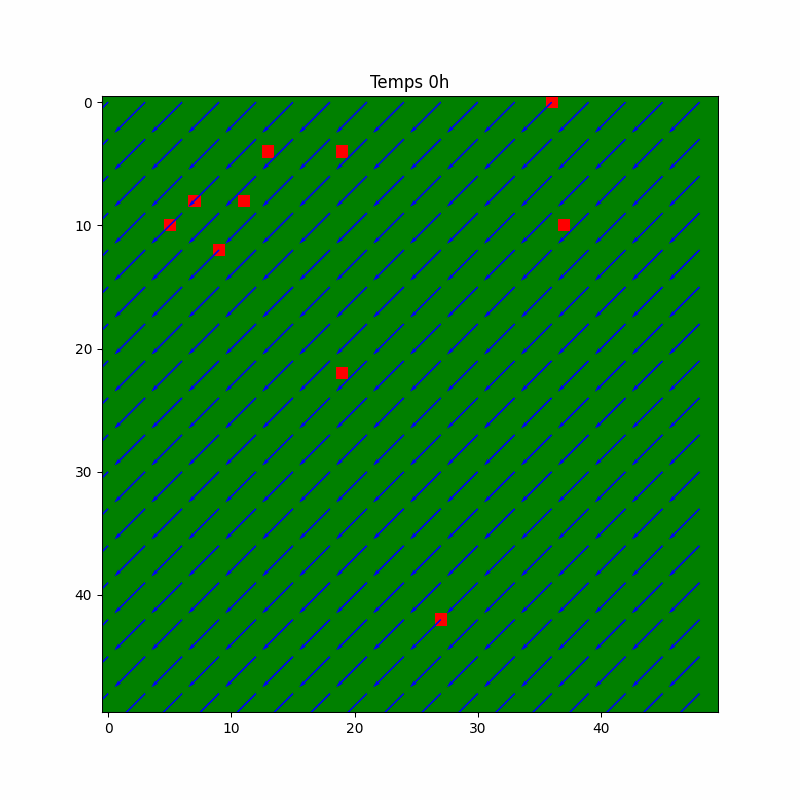

In [156]:
make_gif("frames_ambvent", "incendi_amb_vent.gif")